# Proposito del proyecto

Trabajas como data science en Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, estos estan desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas.

A Film Junky Union le interesa:
- Un valor F1 de al menos 0.85.

Para llevar a cabo este proyecto necesitamos:
- Descargar y explorar los datos
- Analizar los datos
- Preprocesar los datos para poder trabajar el textos como vectores
- Entrenar y probar modelos
- Trabajaremos con modelos preprocesados con **BERT**

## Inicialización

In [1]:
#Instalamos las bibliotecas necesarias
!pip install spacy
!pip install torch
!pip install transformers

In [2]:
#Importamos las librerias necesarias
import math
import numpy as np
import pandas as pd
import spacy
import re 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
import nltk
import torch
import transformers

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm


In [3]:
#descargamos los recursos necesarios
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adrik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adrik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Cargar datos

In [6]:
#cargamos los datos
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})    

### Explorar datos iniciales

**Características**

- *tconst — Es un identificador único para cada título en la base de datos.*

- *title_type — Indica el tipo de título al que se refiere la fila. Puede ser "movie" para películas o "tvSeries" para series de televisión, entre otros posibles valores.*

- *primary_title — Es el título principal o el título en el idioma original de la película o programa de televisión.*

- *original_title — Representa el título original del contenido, es decir, el título en el idioma en el que fue producido originalmente.*

- *start_year — Indica el año de lanzamiento o estreno del título.*

- *end_year — En caso de que el título sea una serie de televisión, esta columna mostraría el año en que finalizó la serie. Para películas o títulos que no son series, es posible que esta columna tenga valores nulos o no se utilice.*

- *runtime_minutes — Es la duración en minutos del contenido, es decir, la duración de una película o la duración promedio de un episodio en una serie de televisión.*

- *is_adult — Es un valor binario que indica si el contenido está dirigido principalmente a un público adulto. Puede ser 1 (sí) o 0 (no).*

- *genres — Muestra los géneros o categorías principales a las que pertenece el título, como acción, comedia, drama, etc. Un título puede tener varios géneros separados por comas.*

- *average_rating — Representa la calificación promedio del título basada en las valoraciones de los usuarios o críticos.*

- *votes — Indica la cantidad total de votos o valoraciones que ha recibido el título.*

- *review — Es un resumen o extracto de una revisión o crítica del título.*

- *rating — Es la calificación asignada al título por parte de los revisores o críticos.*

- *sp — Representa un valor relacionado con el puntaje (score) del título, en nuestro dataset se representa con negativo y positivo.*

- *ds_part — 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente*

- *idx — Es un índice o número de identificación asociado al título.*

- *review_norm — Es una calificación normalizada o ajustada de la revisión, posiblemente basada en una escala específica. Tenemos en nuestro conjunto de datos solo valores Ellipsis, que significa que no hay información proporcionada.*

**Objetivo**

- *pos — el objetivo, '0' para negativo y '1' para positivo*

In [7]:
#Observamos los datos
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
#revisamos el tamaño
df_reviews.shape

(47331, 17)

In [9]:
#verificamos las columnas
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

In [10]:
#revisamos la información general
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [11]:
#buscamos valores nulos
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [12]:
#buscamos valores duplicados
df_reviews.duplicated().sum()

0

Observamos que nuestro dataset tiene los siguientes problemas a resolver:
1. Valores nulos
  - average_rating
  - votes 
2. Tipos de datos incorrectos
  - end_year
  - runtime_minutes
  
Pero para nuestro proposito solo necesitamos los datos de las siguientes columnas:
- review
- pos
- ds_part

Estas características son las que nos ayudaran a predecir si una crítica es negativa, y como estas características no presentan ningún problema, decidimos seguir nuestro análisis sin realizar ningún cambio.

### EDA

Observamos la distribución de nuestros datos para saber cual es el rango de años que estamos abarcando en nuestro estudio, luego realizaremos una segmentación para poder apreciar el número de películas para cada año y el número de reseñas existentes en ese año. 

In [13]:
#observamos la distribución de los datos
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Podemos observar que tenemos un rango de años que abarca desde 1894 - 2010, esto nos deja un período de estudio de 116 años, como es una gran cantidad de años, no podemos visualizarlo todo en una unica gráfica, lo segmentaremos en partes, dividiremos en dos partes los 116 años que tenemos de datos y partiremos de de 1894, los que nos deja como resultado estos dos períodos:
- Período 1 : 1894 - 1952
- Período 2 : 1953 - 2010

Veamos el número de películas y reseñas a lo largo de los años.

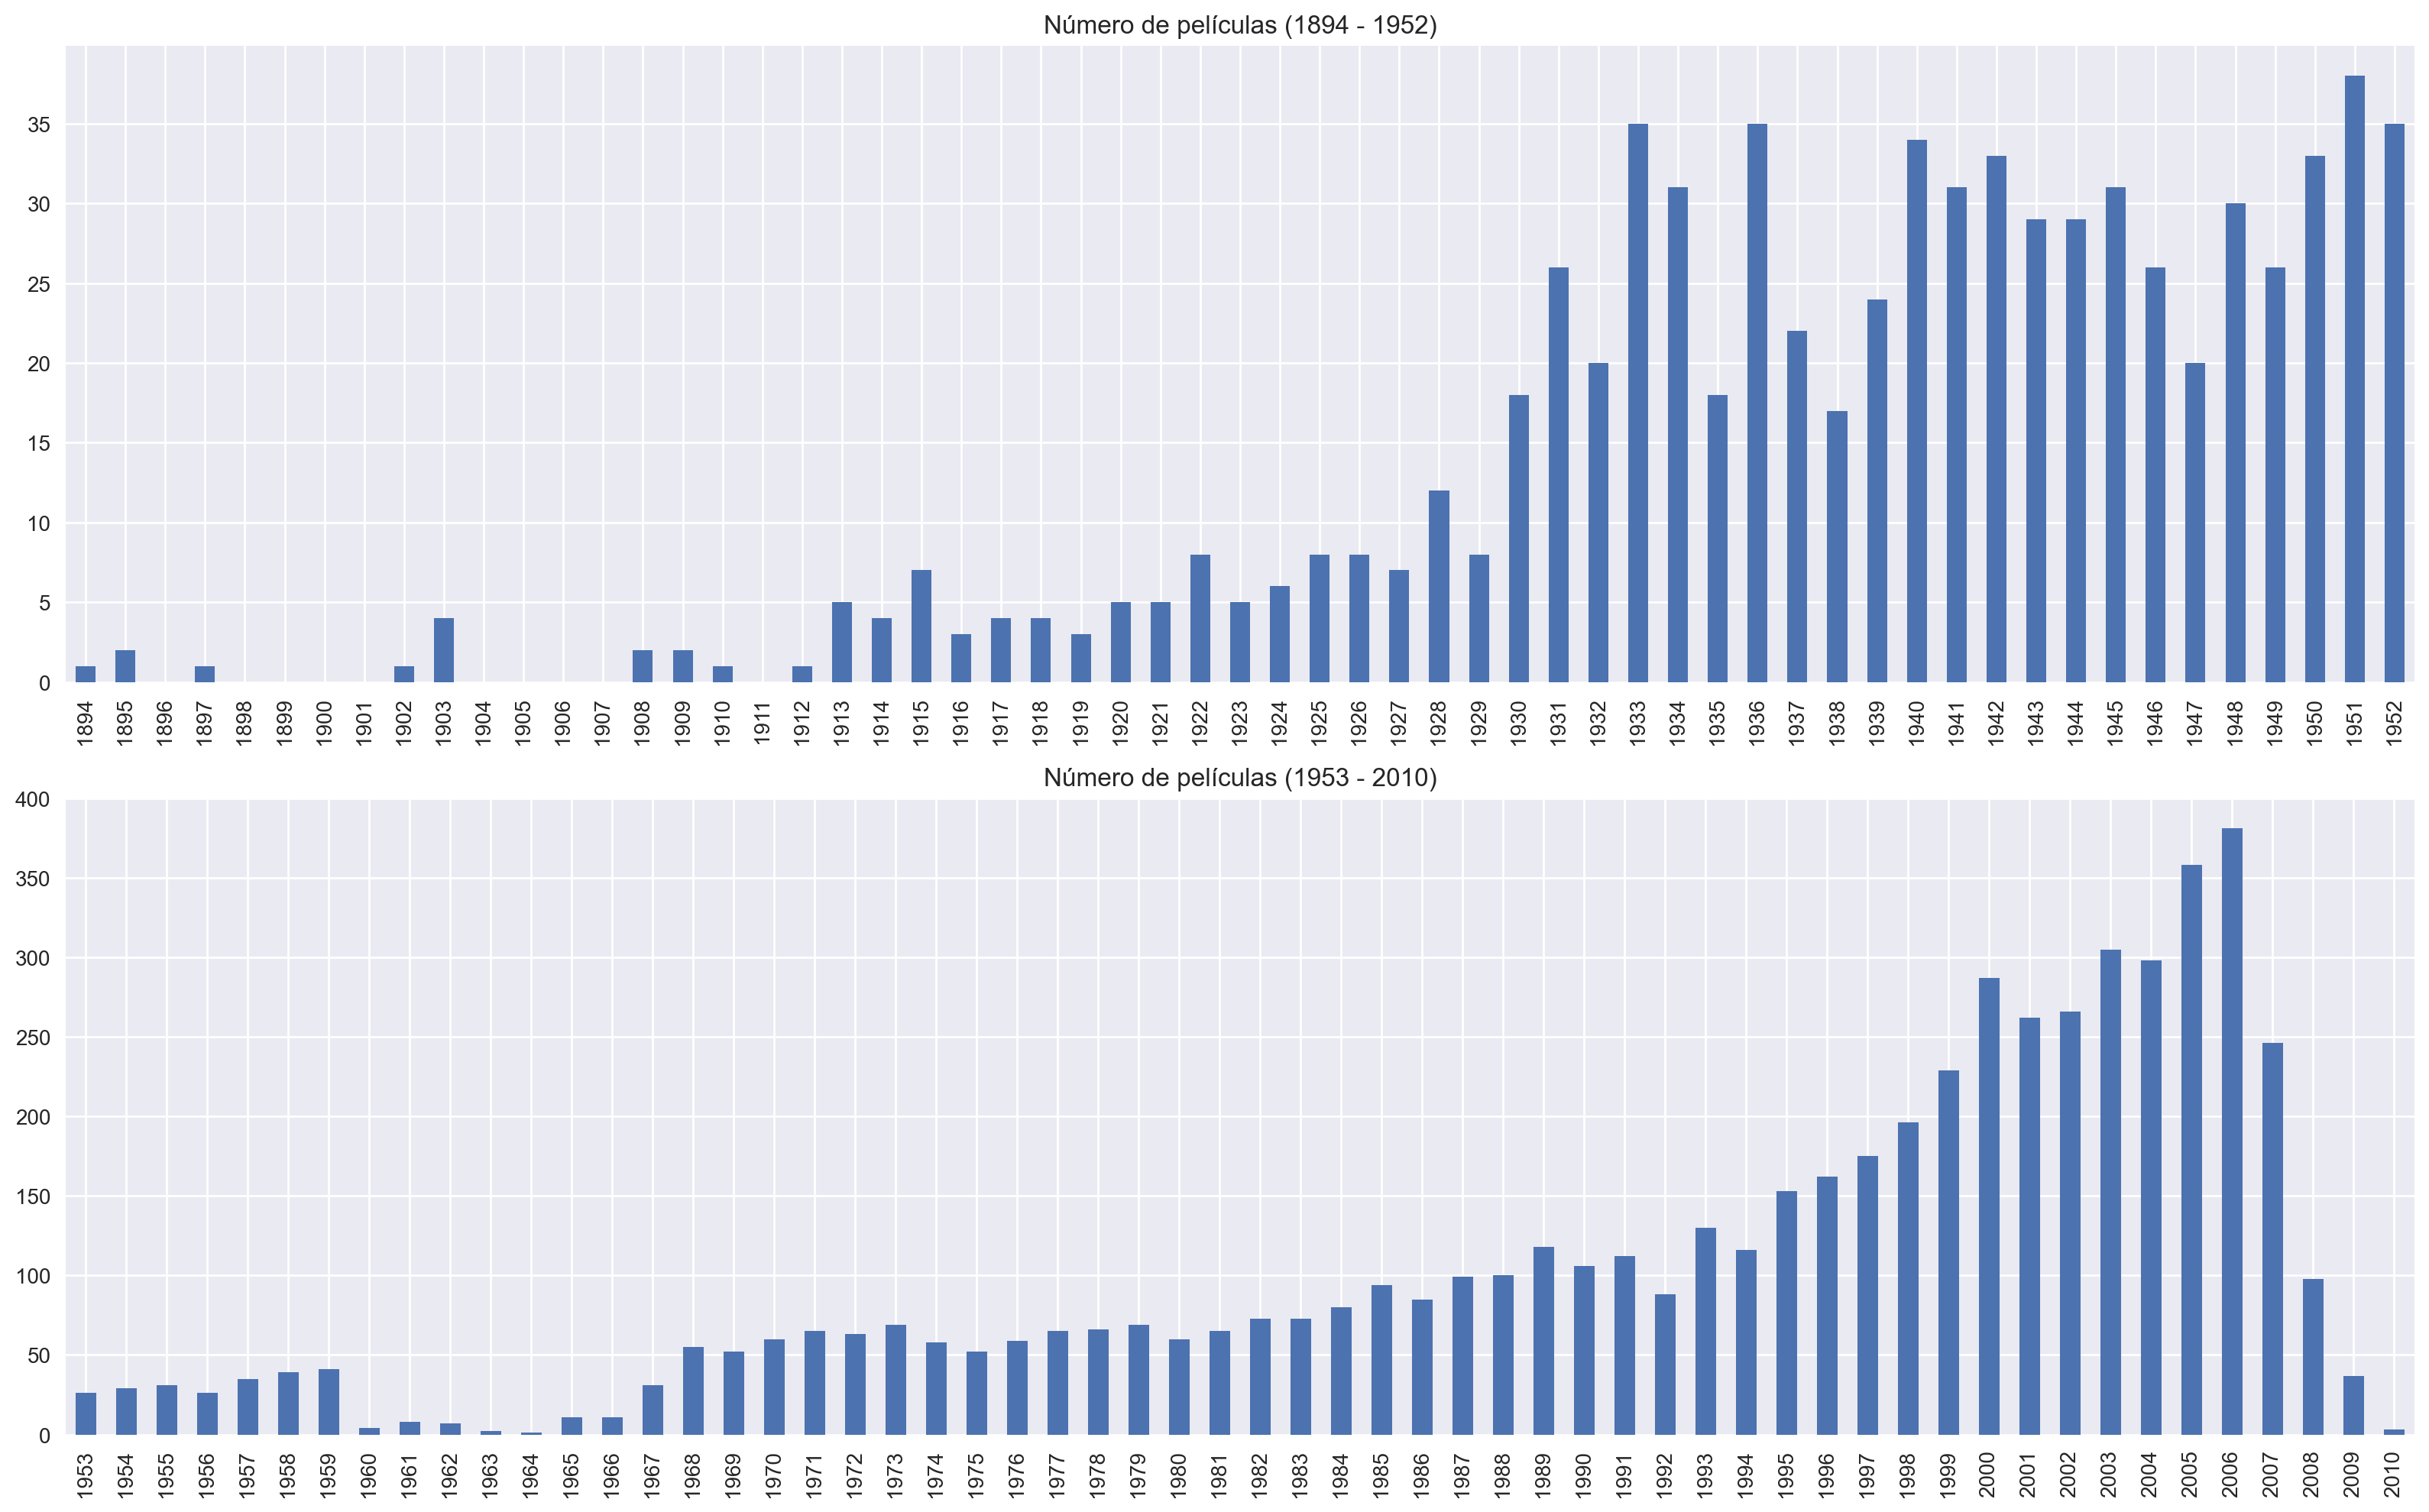

In [14]:
# Filtrar datos para el primer período (1894 - 1952)
df_period1 = df_reviews[(df_reviews['start_year'] >= 1894) & (df_reviews['start_year'] <= 1952)]

# Filtrar datos para el segundo período (1953 - 2010)
df_period2 = df_reviews[(df_reviews['start_year'] >= 1953) & (df_reviews['start_year'] <= 2010)]

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

# Primer subgráfico para el primer período (1894 - 1952)
ax = axs[0]

dft1_period1 = df_period1[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1_period1 = dft1_period1.reindex(index=np.arange(1894, 1953)).fillna(0)
dft1_period1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas (1894 - 1952)')

# Segundo subgráfico para el segundo período (1953 - 2010)
ax = axs[1]

dft1_period2 = df_period2[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1_period2 = dft1_period2.reindex(index=np.arange(1953, 2011)).fillna(0)
dft1_period2.plot(kind='bar', ax=ax)
ax.set_title('Número de películas (1953 - 2010)')

fig.tight_layout()
plt.show()

Observamos que entre el período de 1933 -1959 la cantidad de películas ronda entre los 30 y 50 películas por año, mientras que vemos en entre los años 1970-2006 un aumento muy marcado, con una cantidad de películas de mas de 300 películas por año, un aumento casi exponencial. Podríamos decir que el rango de año que más nos sería útil analizar es de 1970 en adelante. También vemos como el número de películas desciende drásticamente. No sabemos porque se debe este comportamiento inusual pero queda claramente evidenciado.

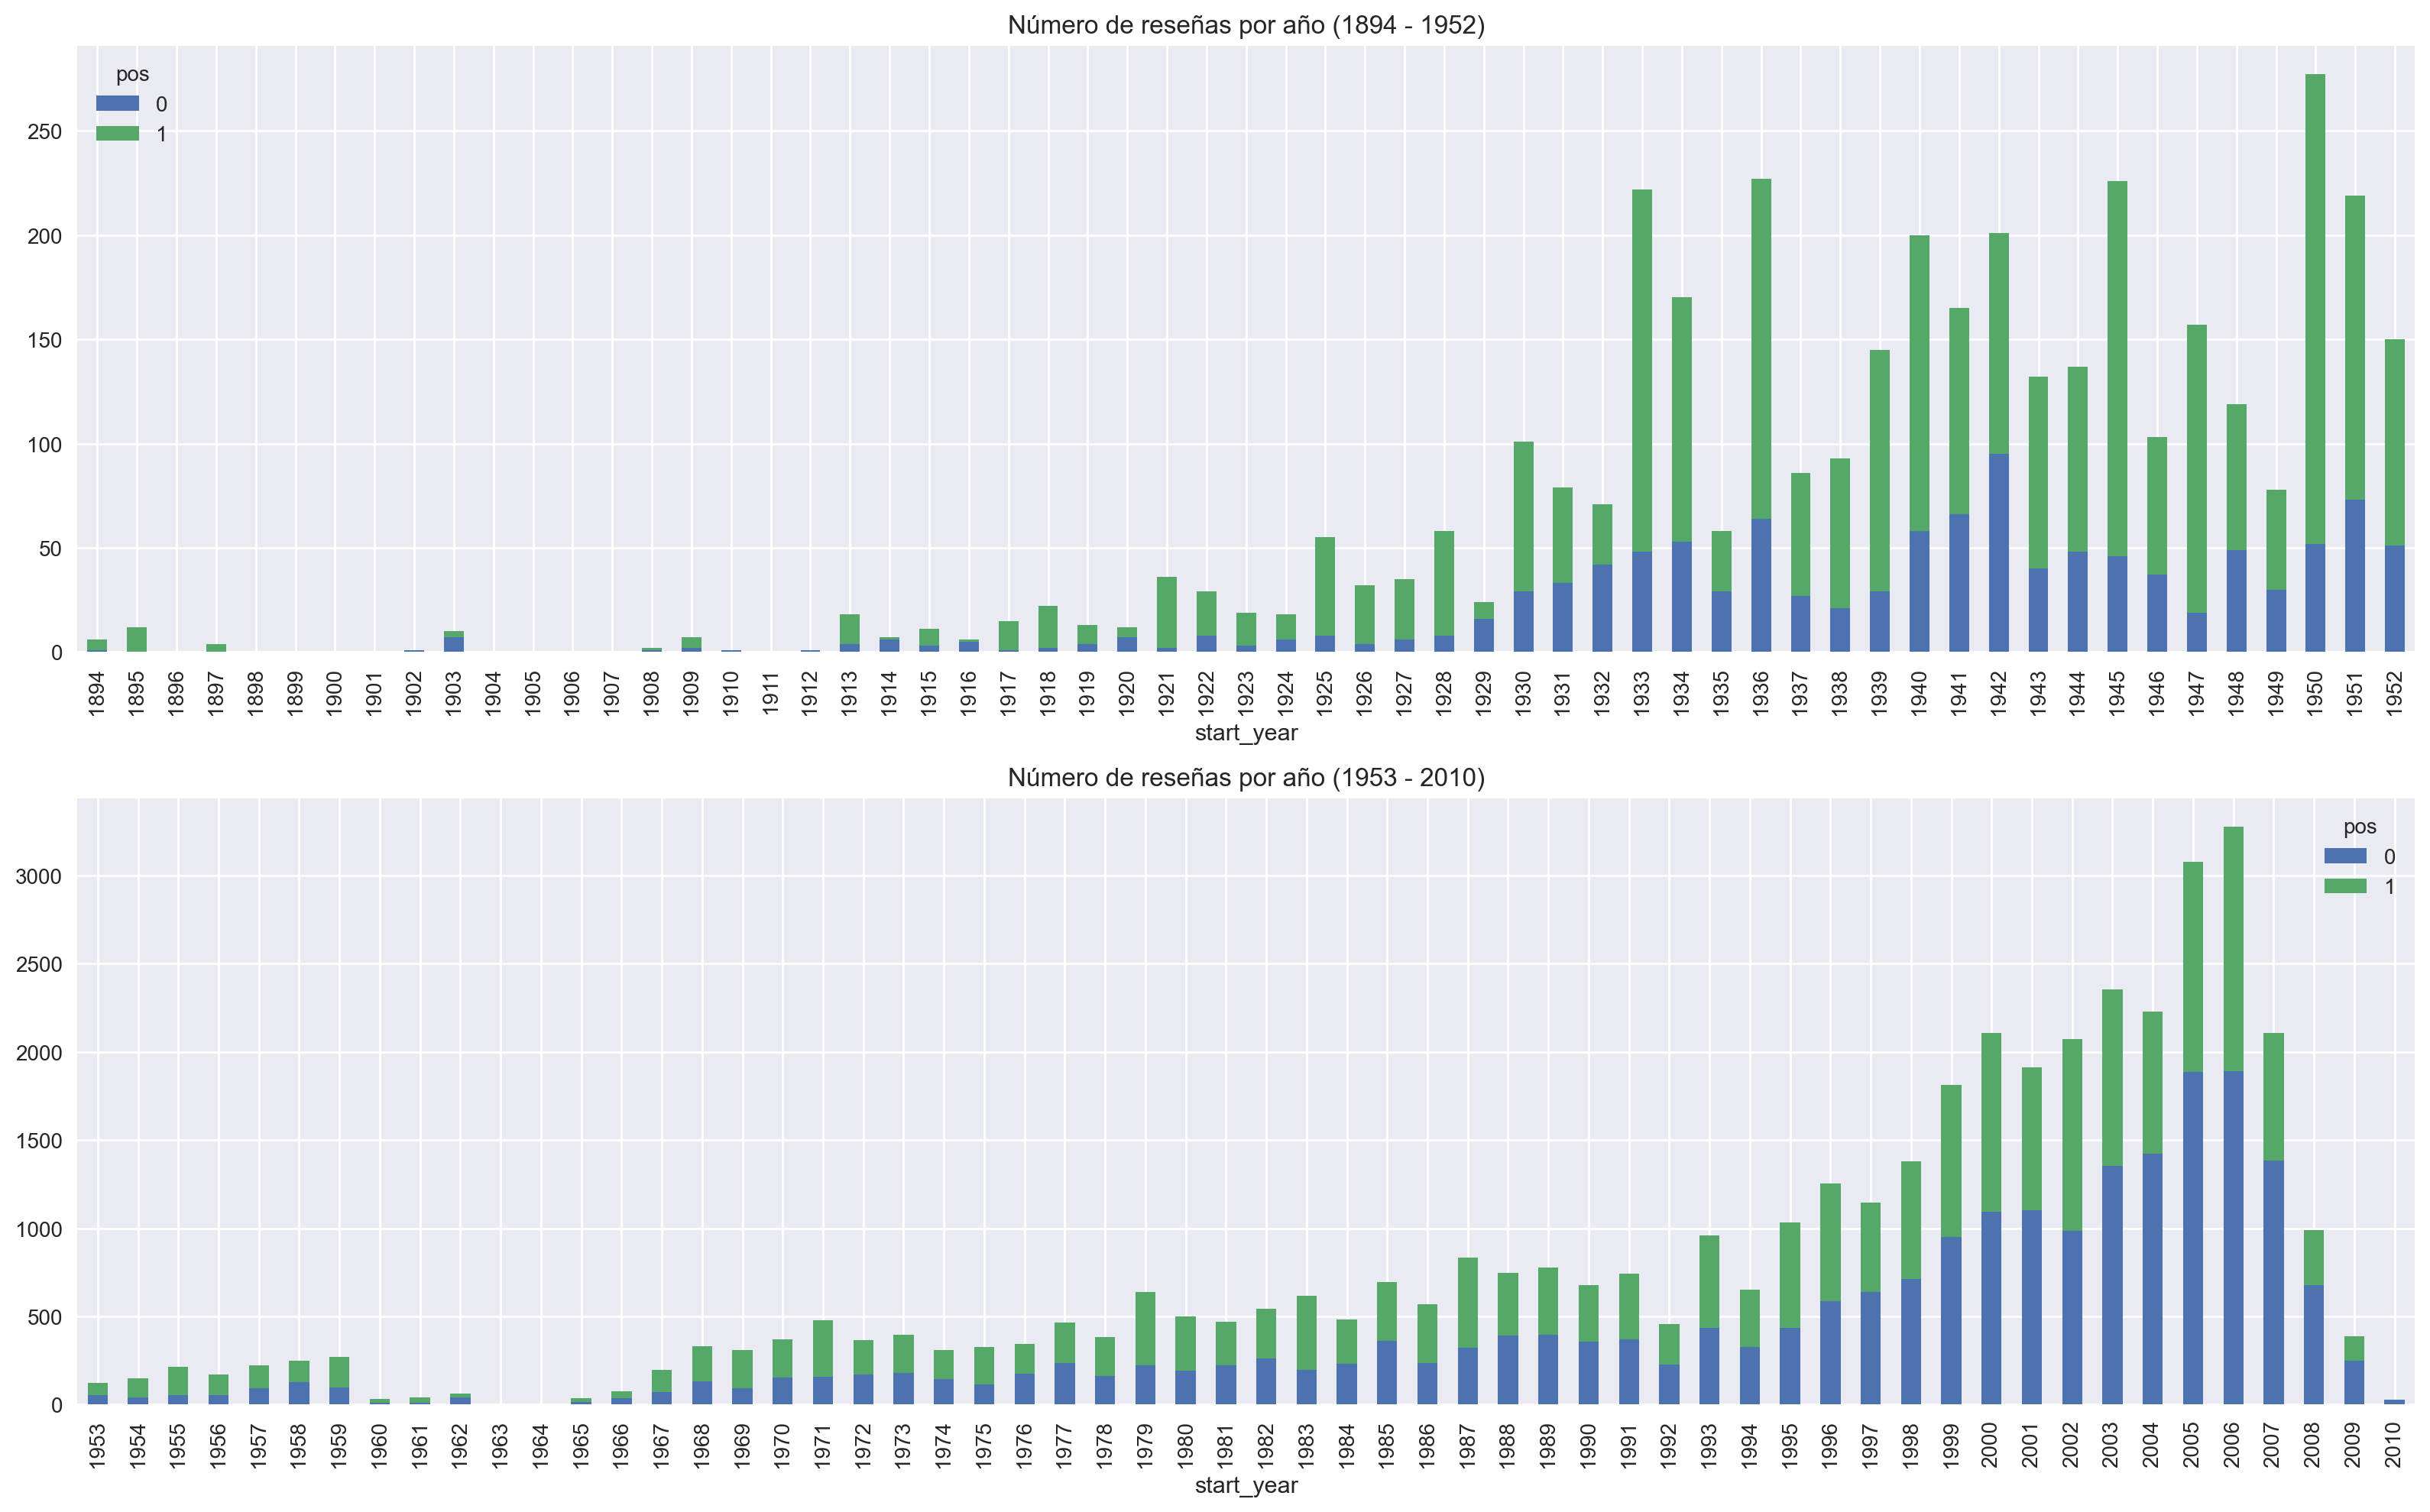

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

# Primer subgráfico para el primer período (1894 - 1952)
ax = axs[0]

dft2_period1 = df_period1.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2_period1 = dft2_period1.reindex(index=np.arange(1894, 1953)).fillna(0)
dft2_period1.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

ax.set_title('Número de reseñas por año (1894 - 1952)')

# Segundo subgráfico para el segundo período (1953 - 2010)
ax = axs[1]

dft2_period2 = df_period2.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2_period2 = dft2_period2.reindex(index=np.arange(1953, 2011)).fillna(0)
dft2_period2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

ax.set_title('Número de reseñas por año (1953 - 2010)')
fig.tight_layout()
plt.show()



Utilizamos la misma segmentación para analizar las reseñas durante cada año, vemos el mismo comportamiento para el período de 1933-1959 un aumento en las reseñas (lo que tiene sentido, si hay más películas) oscilando entre 200 y 300 reseñas por año. Mientras que en el período de de 1979-2006 se nota un marcado ascenso de reseñas, llegando a superar las 3000 reseñas por año (2005-2006). Luego vemos el fuerte descenso visto en el gráfico anterior. Observemos que para nuestro primer período existen mas reseñas positivas que negativas, no siendo igual para el segundo período estudiado, vemos un equilibrio entre reseñas positivas y negativas, incluso podriamos inferir que existe una ligera inclinación hacias las reseñas negativas. Haremos una análisis para corroborar estas inferencias.

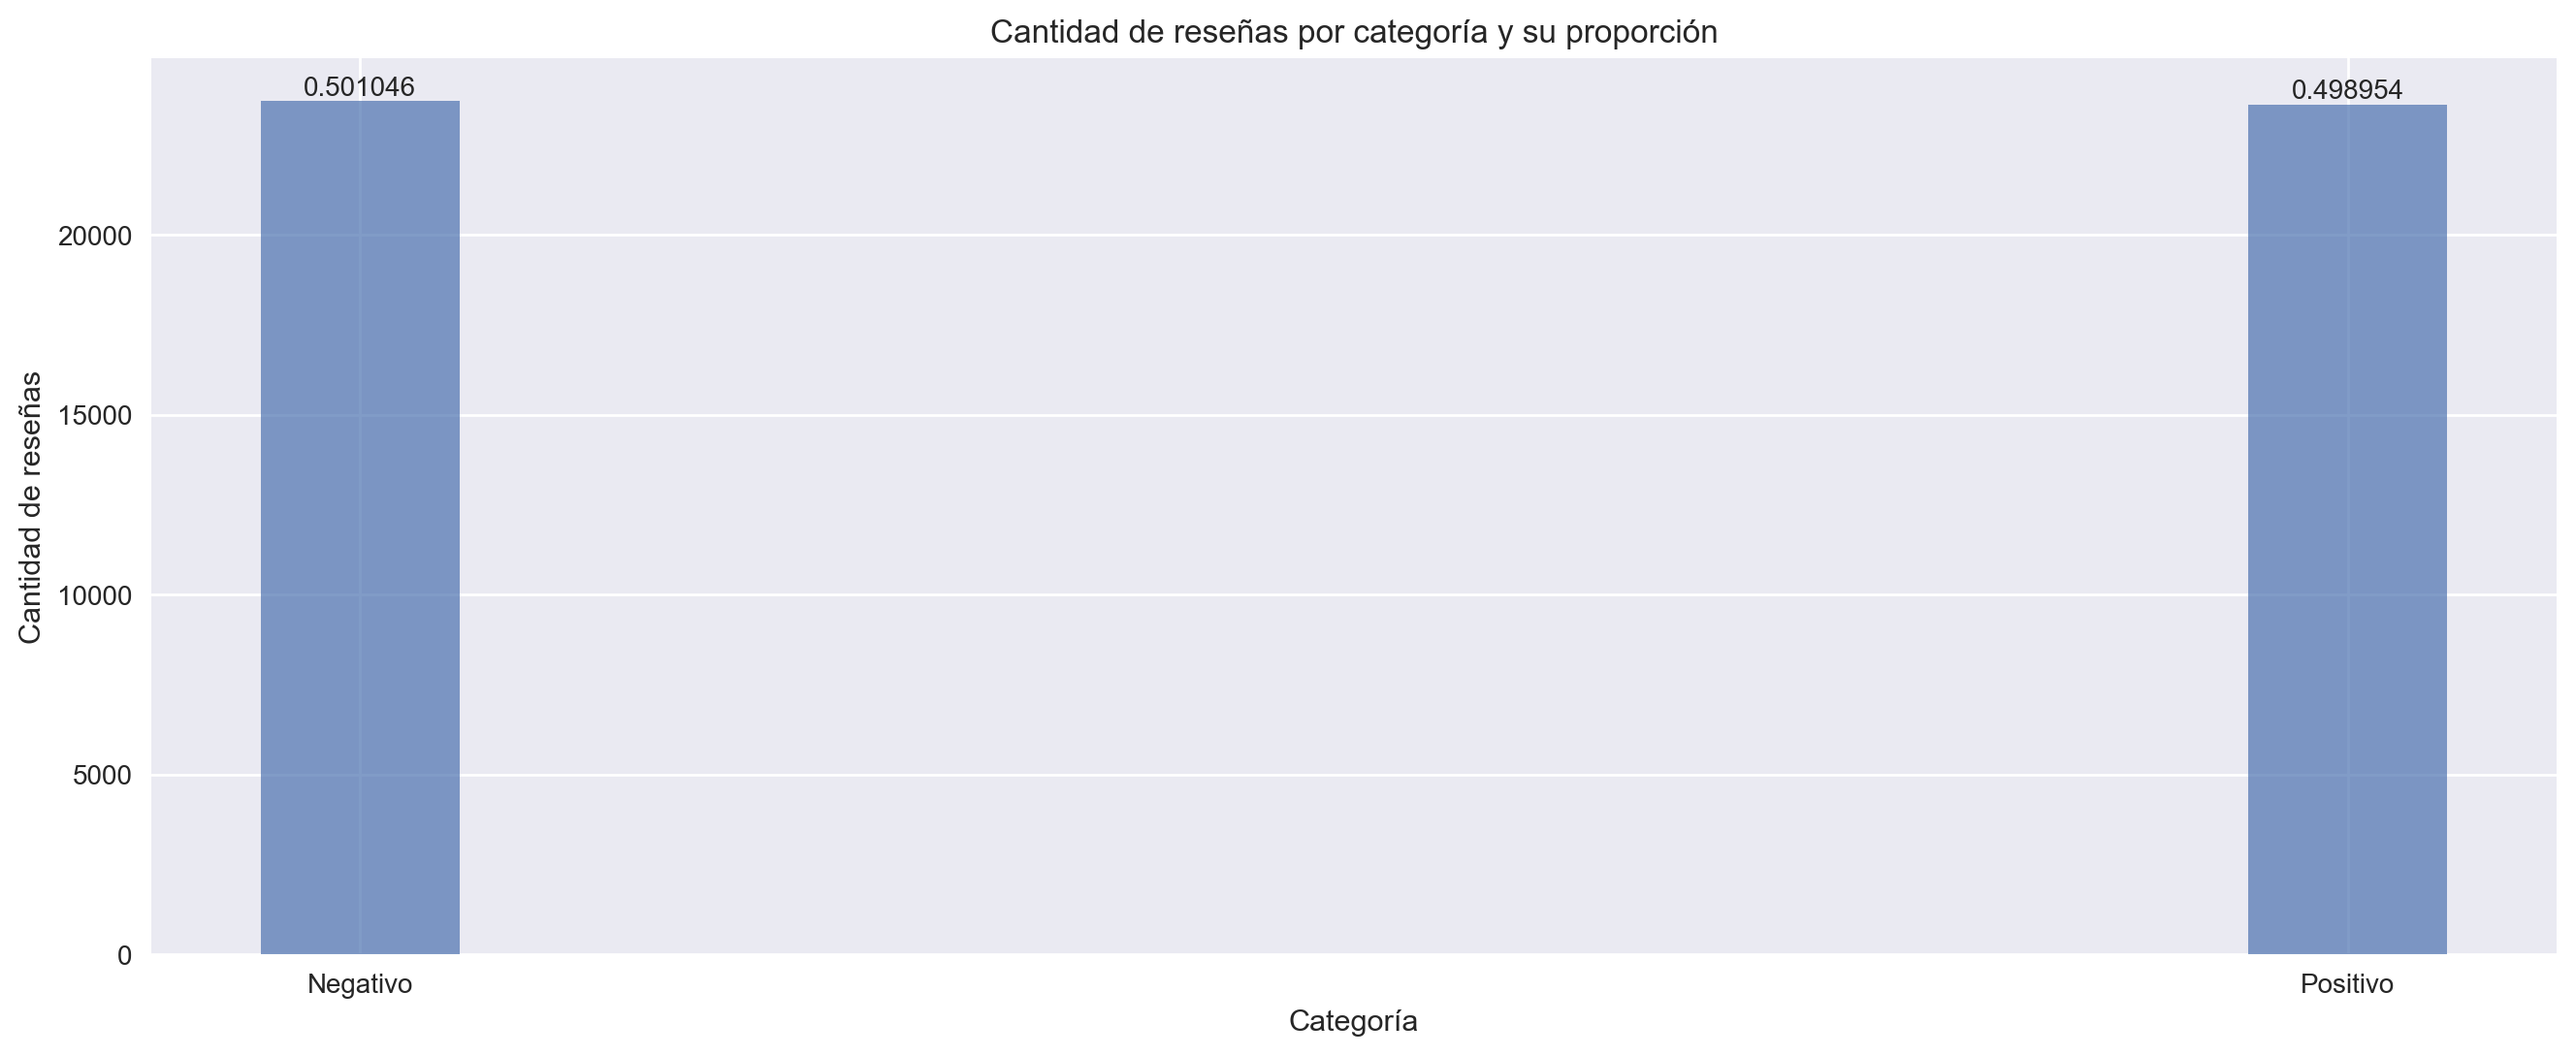

In [16]:
#Obtenemos el recuento de valores únicos para cada categoría
count_categories = df_reviews['pos'].value_counts(normalize=True)

# Crear el gráfico de barras
plt.figure(figsize=(16, 6))

# Crear las barras de cantidad de reseñas
bars = plt.bar(x=count_categories.index, height=df_reviews['pos'].value_counts(), width=0.1, alpha=0.7)

# Añadir etiquetas de categoría en el eje x
plt.xticks(count_categories.index, ['Negativo', 'Positivo'])

# Añadir etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Cantidad de reseñas')
plt.title('Cantidad de reseñas por categoría y su proporción')

# Mostrar proporciones arriba de las barras
for bar, prop in zip(bars, count_categories):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{prop:.6f}', ha='center', va='bottom')

plt.show()


Al observar nuestro gráfico de barras podemos ver que ambas categorías presentan una cantidad muy similar de reseñas, que al redondeo sería una proporción 50-50. No observamos desequilibrio de clase. Nuestro datos estan segmentados en prueba y entrenamiento, veamos si en estas segmentaciones las categorías siguen presentando equilibrio de clases. 

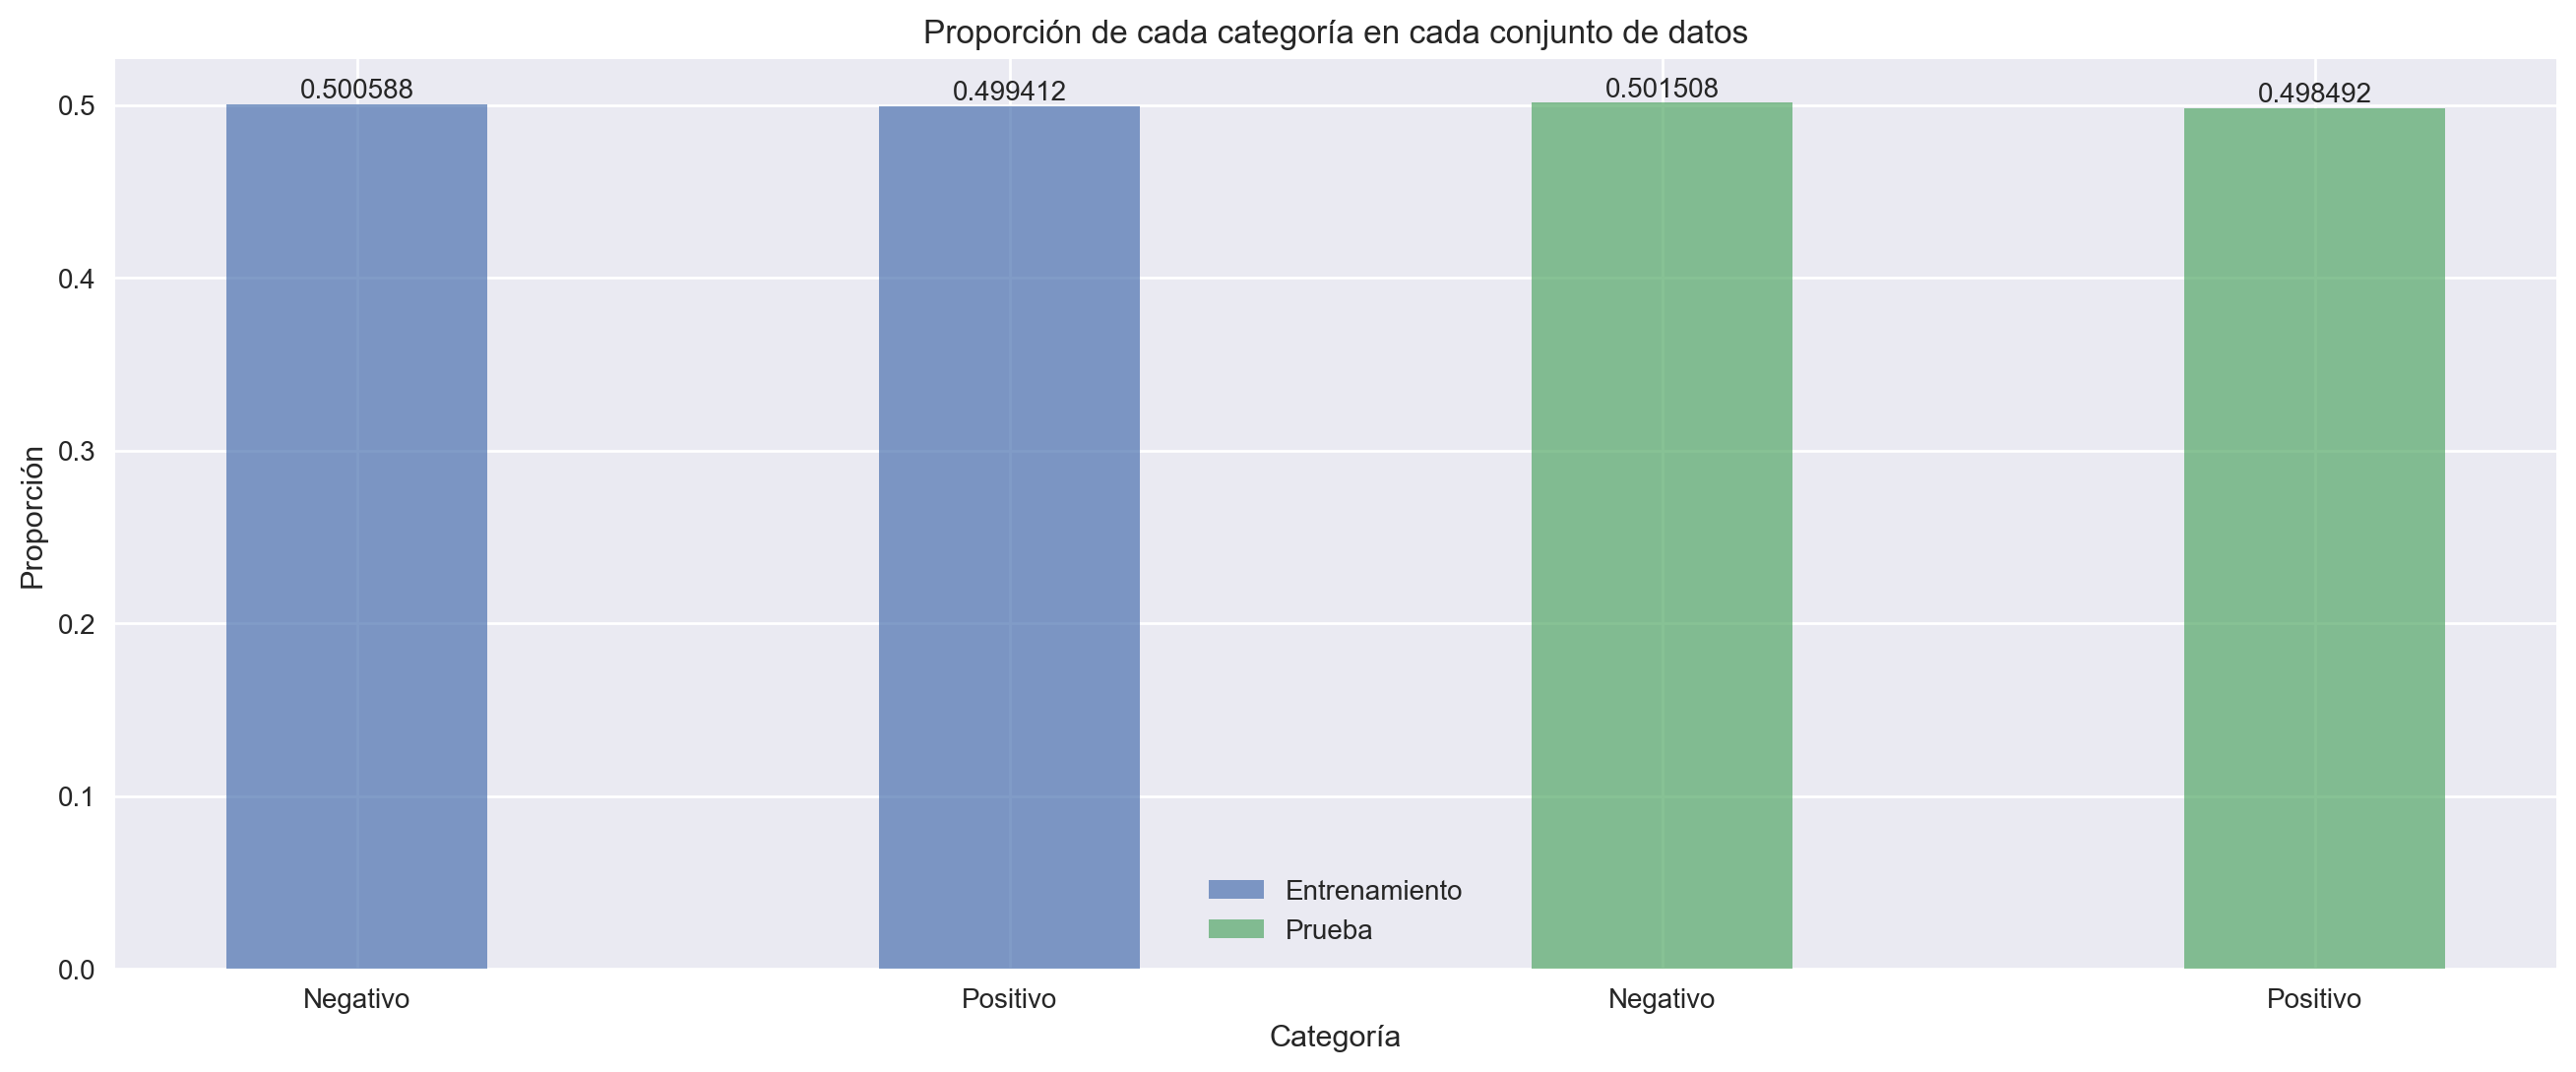

In [17]:
# Obtener el recuento de valores únicos para cada categoría y conjunto de datos
count_categories_train = df_reviews[df_reviews['ds_part'] == 'train']['pos'].value_counts(normalize=True)
count_categories_test = df_reviews[df_reviews['ds_part'] == 'test']['pos'].value_counts(normalize=True)

# Crear el gráfico de barras
plt.figure(figsize=(16, 6))

# Crear las barras de cantidad de reseñas para el conjunto de entrenamiento
bars_train = plt.bar(x=[0, 1], height=[count_categories_train[0], count_categories_train[1]], width=0.4, alpha=0.7)
# Crear las barras de cantidad de reseñas para el conjunto de prueba
bars_test = plt.bar(x=[2, 3], height=[count_categories_test[0], count_categories_test[1]], width=0.4, alpha=0.7)

# Añadir etiquetas de categoría en el eje x
plt.xticks([0, 1, 2, 3], ['Negativo', 'Positivo', 'Negativo', 'Positivo'])

# Añadir etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Proporción')
plt.title('Proporción de cada categoría en cada conjunto de datos')

# Mostrar proporciones arriba de las barras
for bar_train, bar_test, prop_train, prop_test in zip(bars_train, bars_test, count_categories_train, count_categories_test):
    plt.text(bar_train.get_x() + bar_train.get_width() / 2, bar_train.get_height(), f'{prop_train:.6f}', ha='center', va='bottom')
    plt.text(bar_test.get_x() + bar_test.get_width() / 2, bar_test.get_height(), f'{prop_test:.6f}', ha='center', va='bottom')

# Agregar leyenda
plt.legend(['Entrenamiento', 'Prueba'])

plt.show()


Observamos en nuestro gráfico segmentado por conjunto de datos y por categoría, que el equilibrio de clase se mantuvo independientemente en un 50% para las reseñas negativas y 49% para las reseñas positivas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

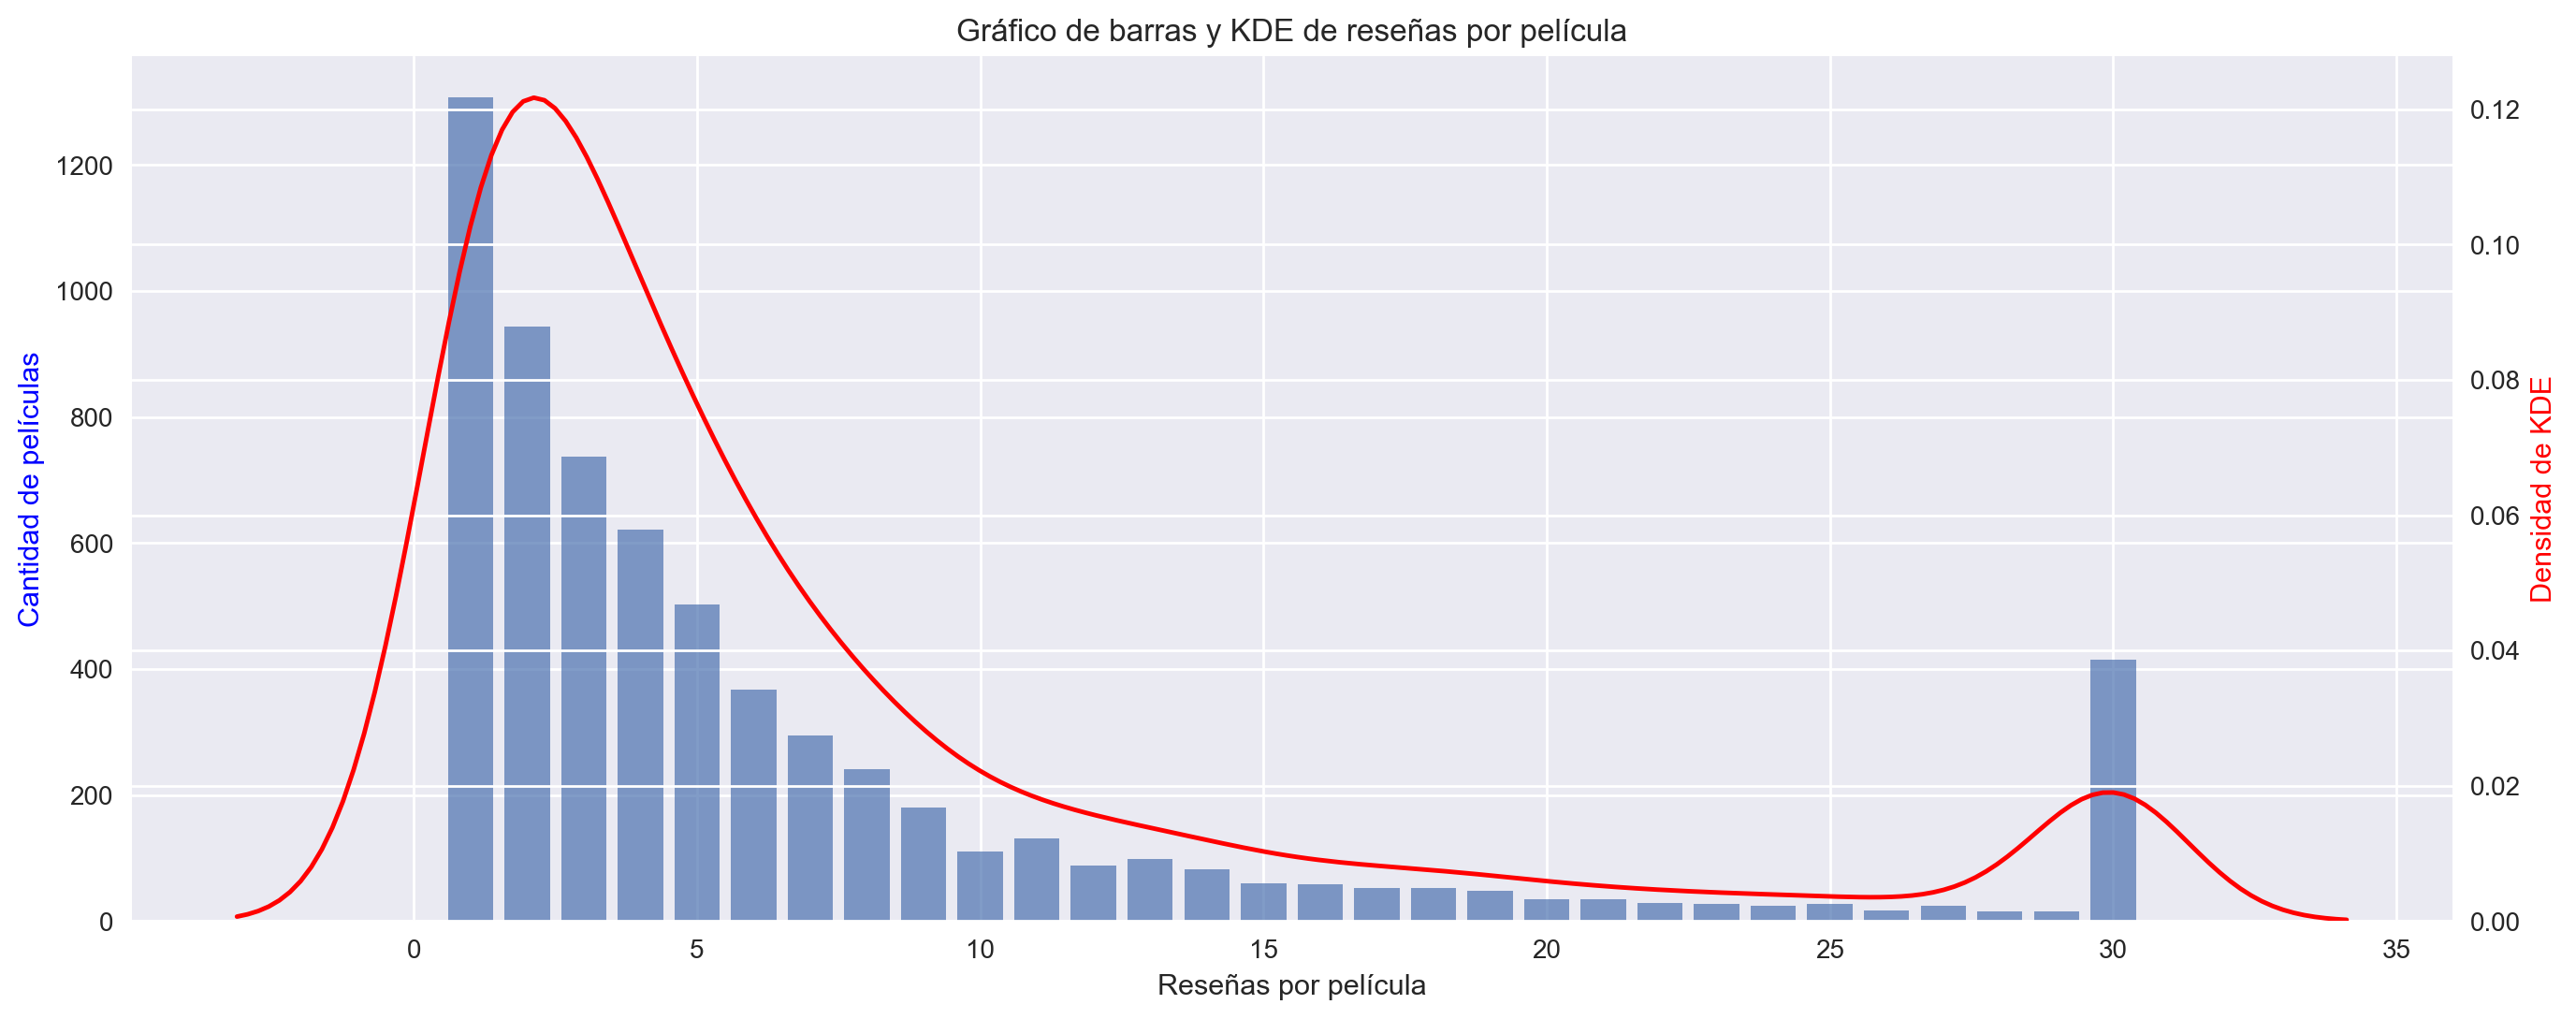

In [18]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Gráfico de barras
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
ax1.bar(dft.index, dft.values, alpha=0.7)
ax1.set_xlabel('Reseñas por película')
ax1.set_ylabel('Cantidad de películas', color='blue')
ax1.set_title('Gráfico de barras y KDE de reseñas por película')

# Gráfico KDE
ax2 = ax1.twinx()
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax2, color='red', label='KDE')
ax2.set_ylabel('Densidad de KDE', color='red')

plt.show()

Observamos que la mayoría de películas (concentradas en las primeras cuatro barras, 3400 películas aprox.), poseen entre 1 a 4 reseñas por película, luego vemos como el número de películas desciende a más cantidad de reseñas para luego encontrar  un pico de 400 películas con 30 reseñas, nuestro gráfico de distribución de densidades muestra los mismos patrones. 

Revisemos con mas detalle estas películas que presentan 30 reseñas.

In [19]:
# Obtener las películas que tienen 30 reseñas
df_reviews_30_resenas = df_reviews.groupby('tconst').filter(lambda x: len(x) == 30)

df_reviews_30_resenas.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
2684,tt0109127,movie,Angels in the Outfield,Angels in the Outfield,1994,\N,102,0,"Comedy,Family,Fantasy",6.2,28310,I have to say despite it's reviews Angels in t...,10,pos,1,train,11927
44002,tt0080040,movie,Tourist Trap,Tourist Trap,1979,\N,90,0,Horror,6.2,7792,A group of friends break down in the middle of...,7,pos,1,test,6228
3571,tt0092603,movie,Babette's Feast,Babettes gæstebud,1987,\N,103,0,Drama,7.8,17482,I just watched this film this morning and I fo...,9,pos,1,test,10467
42946,tt0073906,movie,The Wind and the Lion,The Wind and the Lion,1975,\N,119,0,"Action,Adventure,Drama",6.9,7925,We usually think of the British as the experts...,10,pos,1,test,1168
15729,tt0116477,movie,Hamlet,Hamlet,1996,\N,242,0,Drama,7.7,35360,"(Sorry for my faulty language, i am no native ...",10,pos,1,train,2479
23874,tt0277941,movie,Ned Kelly,Ned Kelly,2003,\N,110,0,"Action,Adventure,Biography",6.5,25239,Definitely one of my favourite movies. The sto...,10,pos,1,train,243
47267,tt0120907,movie,eXistenZ,eXistenZ,1999,\N,97,0,"Horror,Sci-Fi,Thriller",6.8,91631,This movie is breath-taking and mind-blowing. ...,8,pos,1,test,1980
4404,tt0286499,movie,Bend It Like Beckham,Bend It Like Beckham,2002,\N,112,0,"Comedy,Drama,Romance",6.6,102534,"""Bend It Like Beckham"" reminds me of the best ...",7,pos,1,train,2785
22694,tt0093565,movie,Moonstruck,Moonstruck,1987,\N,102,0,"Comedy,Drama,Romance",7.1,47639,"Even thought I'm not the biggest of Cher fans,...",4,neg,0,train,455
44873,tt0081696,movie,Urban Cowboy,Urban Cowboy,1980,\N,132,0,"Drama,Romance,Western",6.3,12781,"John Travolta, the biggest honkeytonk in the w...",7,pos,1,train,5101


No se observa ningún patrón aparente, podriamos inferir que fueron muy populares en su momento y a eso se debe la alta cantidad de reseñas por título. 

Ahora observaremos la distribución de las puntuaciones para cada conjunto de datos (entrenamiento y prueba).

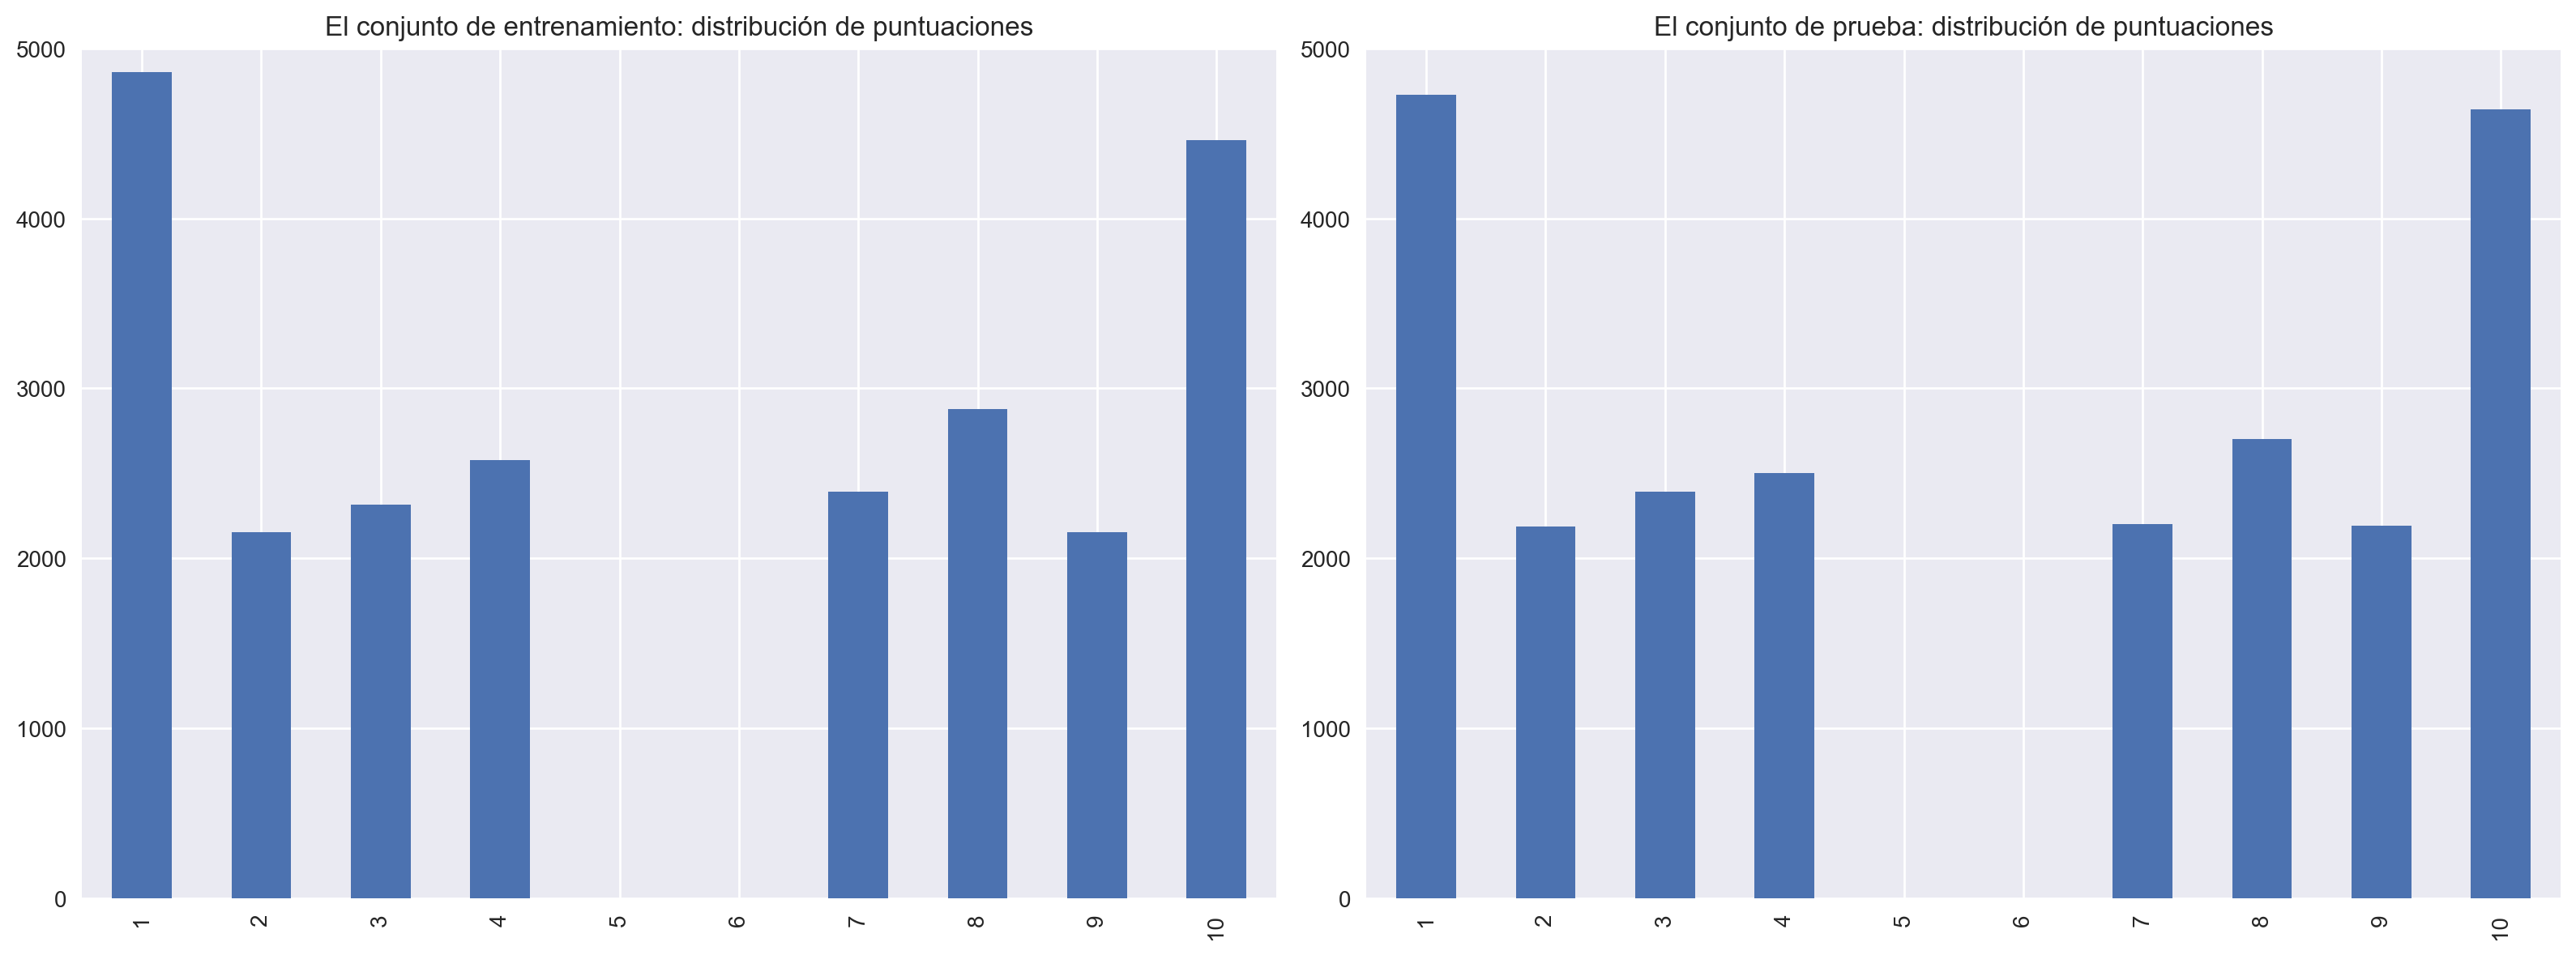

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Podemos detallar que las calificaciones extremas (1-10) son las que mayor número presentan, en ambos conjuntos, por encima de los 4000. En menor medida las calificaciones (2-9) cerca de los 2000, y con la ausencia de los valores (5-6). Podemos inferir que al tener una escala muy segmentada es menos probable que se escogan todas las opciones o quizas hubo un problema para poder seleccionar esta calificación.

Observemos la distribución de reseñas negativas y positivas por película para las dos partes del conjunto de datos.

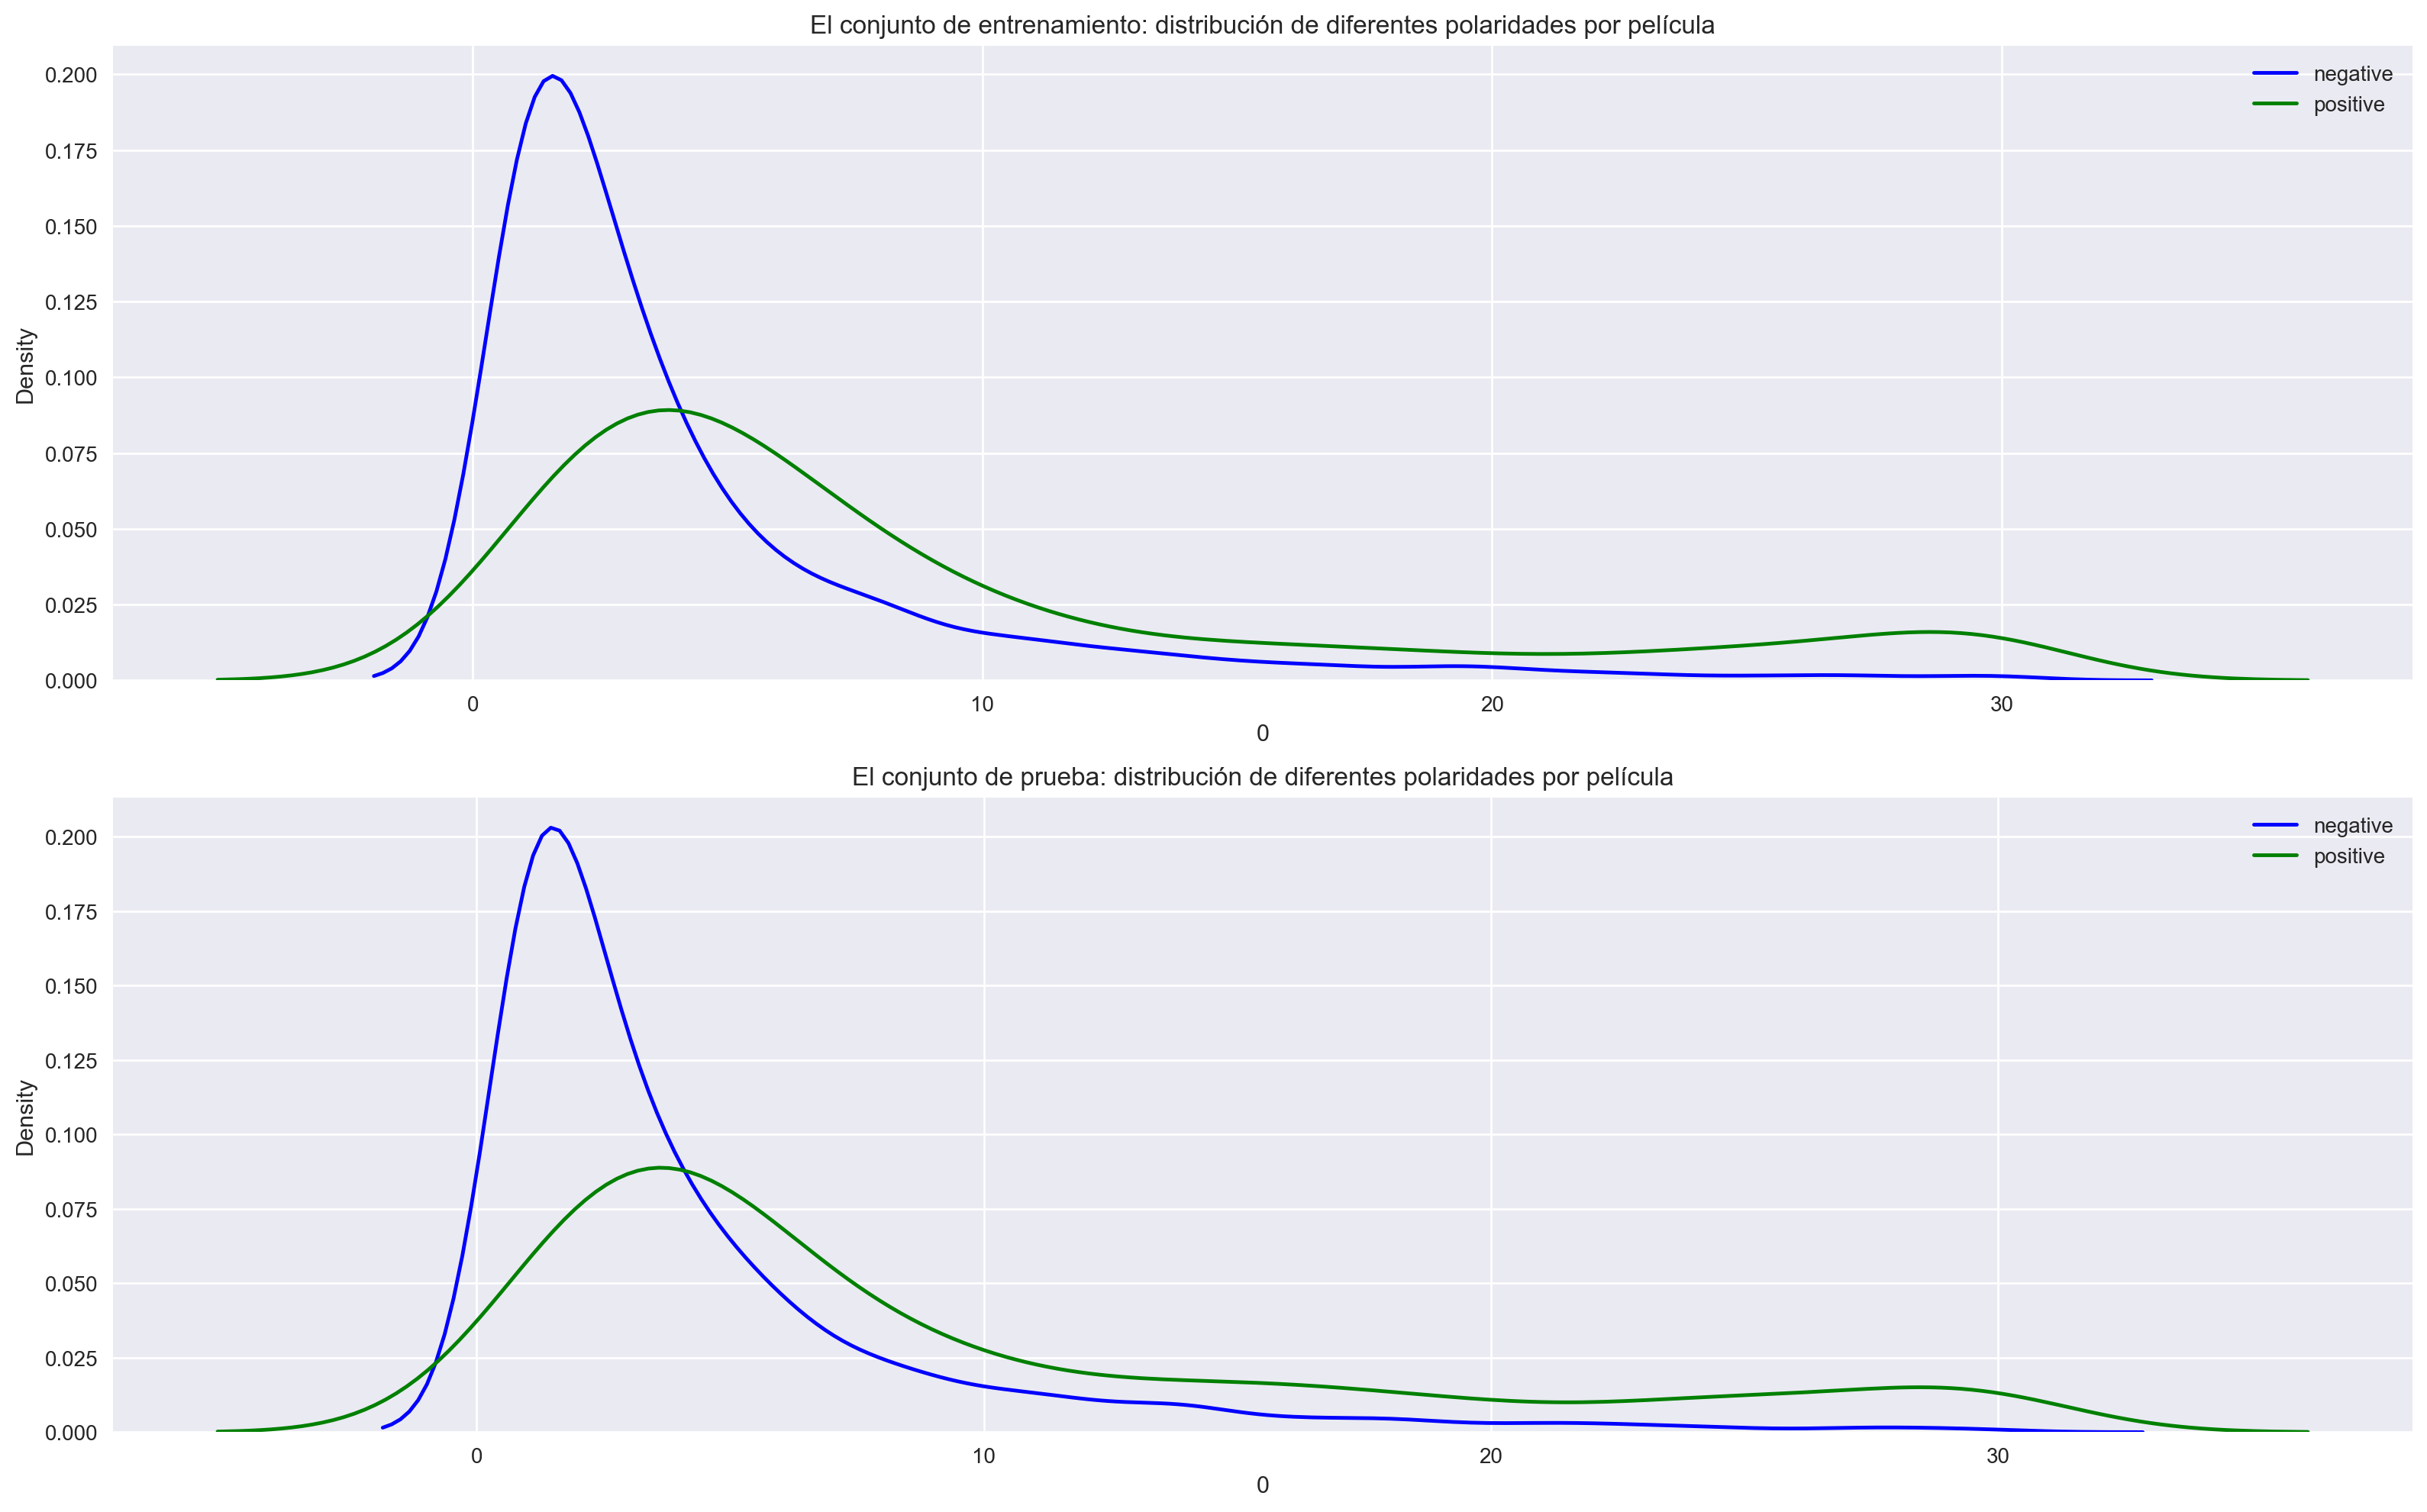

In [21]:
fig, axs = plt.subplots(2,1, figsize=(16, 10))

ax = axs[0]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')


ax = axs[1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()


Podemos observar que la distribución de diferentes polaridades por película en ambos segmentos es muy similar, resalta como aquellas películas con un rango de reseñas entre 1-5, suelen tener mas reseñas negativas que positivas, a partir de allí, el comportamiento muestra cambios, las densidades se cruzan, dejando en claro que mientras mayor sea el número de reseñas estas tienden a ser positivas. También observamos el comportamiendo que vimos anteriormente en el gráfico de número de reseñas, que mostraba un pico en el numero de reseñas en el número 30, para nuestro gráfico actual vemos que eso pico de aumento de reseñas son reseñas positivas. 

## Procedimiento de evaluación

Definiremos la composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto, esta función nos devolverá el F1, la curva ROC, y la curva PRC.

In [22]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc. Para el cual crearemos una función que pueda normalizar las reseñas.

In [23]:
#Creamos una función para la normalización de las reseñas
def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    return text.lower()


In [24]:
#Comprobamos si la normalización funcionó
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)
print(df_reviews['review'][35])
print('---------------------------------------------------------------------------------------------------------')
print(df_reviews['review_norm'][35])

The movie ". . . And The Earth Did not Swallow Him," based on the book by Tomas Rivera, is an eye-opening movie for most people. It talks about the exploitation that migrant farmworkers go through in order to survive. Sergio Perez uses impressionistic techniques to depict Rivera's story. He uses sienna and gray-scale effects to depict some of the scenes, and he uses specific photographic techniques to make the scenes look like they took place in the 1950s. Perez also gives life to the film by using time-appropriate music, including balladeering and guitar playing. I feel that it is a good film to view because it shows in detail how migrant farmworkers live, what they do for entertainment, and their beliefs.
---------------------------------------------------------------------------------------------------------
the movie and the earth did not swallow him based on the book by tomas rivera is an eye opening movie for most people it talks about the exploitation that migrant farmworkers go

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [25]:
#Dividimos el dataset en conjuntos de entrenamiento y prueba, basados en df_part
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Establecemos los objetivos de cada uno de los conjuntos
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

En este proyecto utilizaremos tres tecnicas de preprocesamiento NLTK , spaCy y BERT, que aplicaremos a diferentes modelos como la Regresión Logística y Potenciación de gradiente (LGBM), los cuales someteremos a evaluación con nuestra función creada anteriormente evaluate_model.

### Modelo 0 - Constante

Utilizaremos un modelo DummyClassifier y pasaremos como características la variable review_norm. Para el modelo dummy utilizaremos la estrategia constant que siempre predecira la clase positiva.

In [26]:
#Establecemos las características para ambos conjuntos
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

#Llamamos al modelo Dummy
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(train_features_0 , train_target)

predictions = model_dummy.predict(test_features_0)
predictions = pd.Series(predictions)
predictions.value_counts()

1    23535
dtype: int64

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


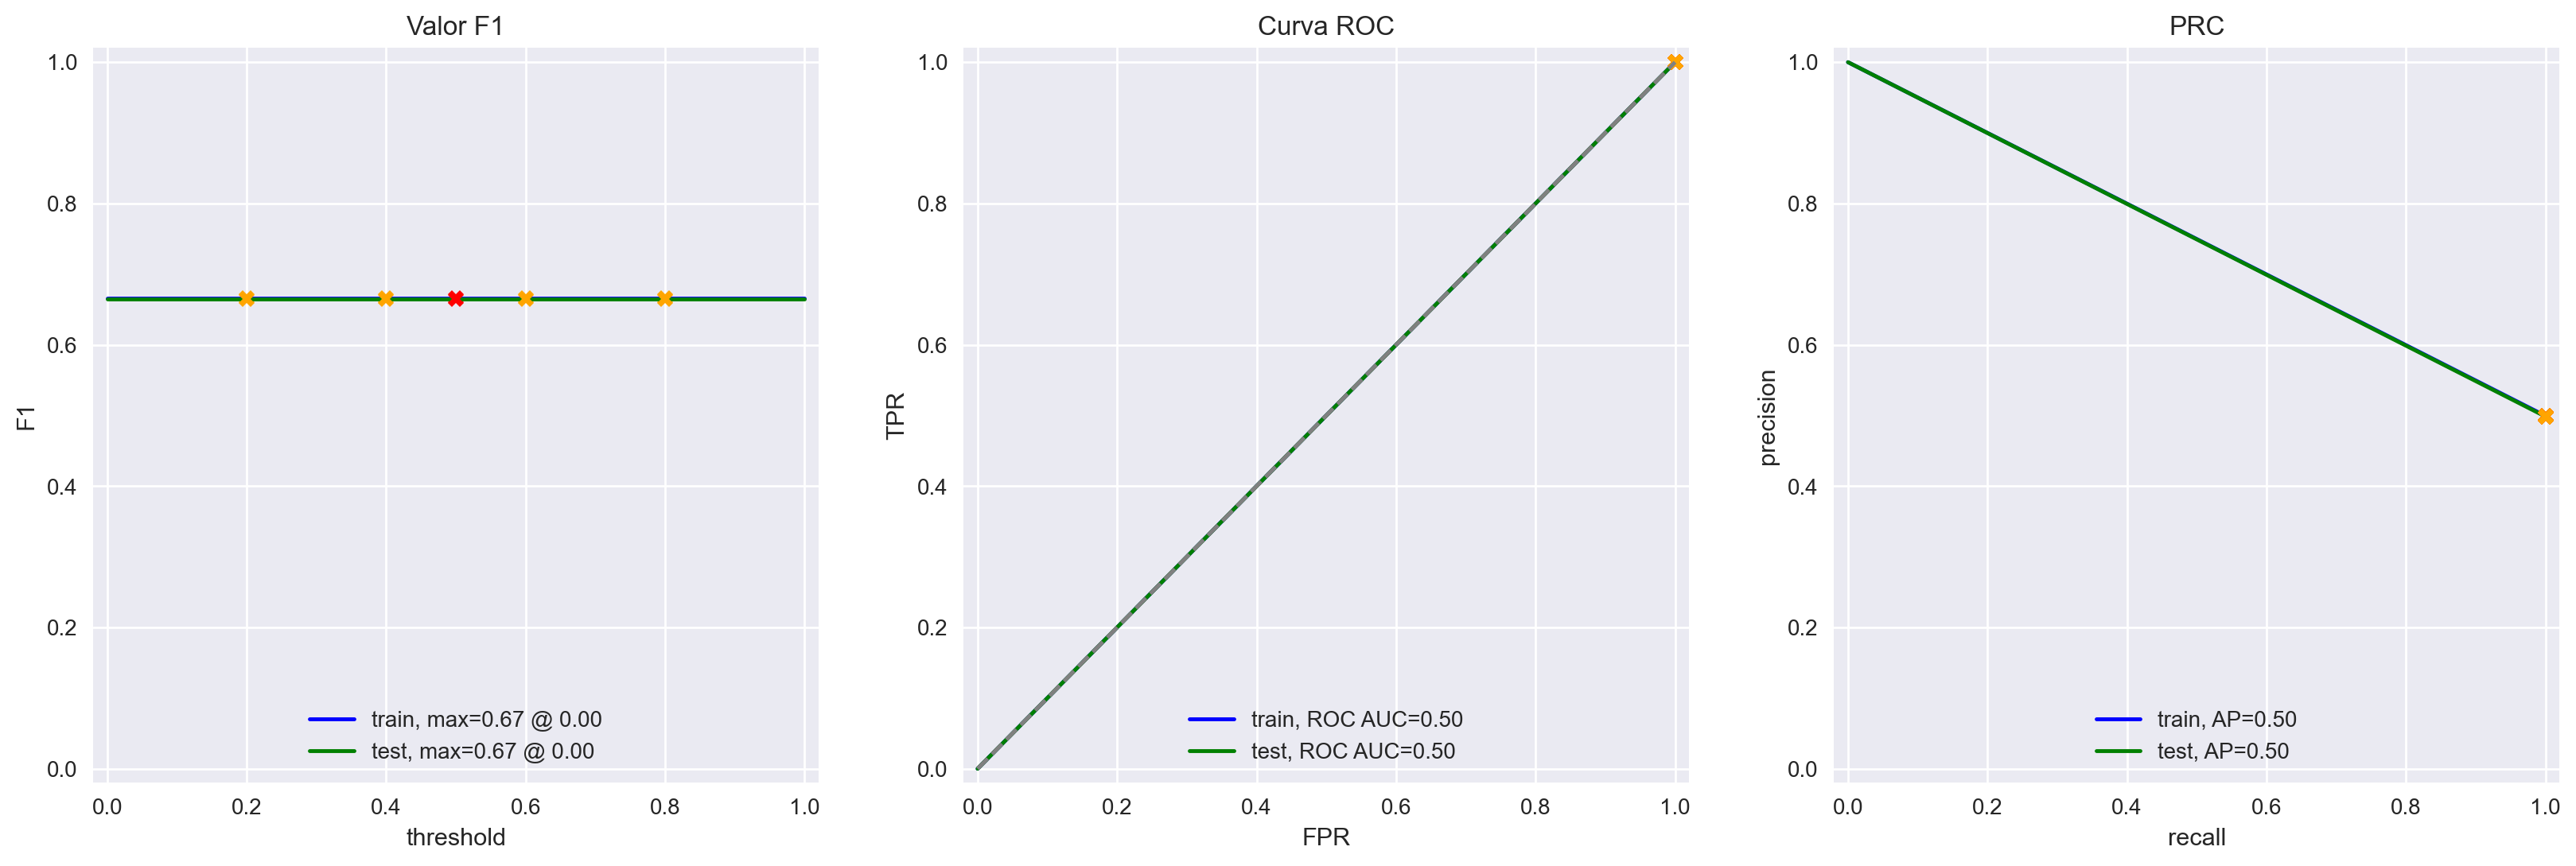

In [27]:
evaluate_model(model_dummy, train_features_0, train_target, test_features_0, test_target)

Observamos que para nuestro modelo constante hemos obtenido una métrica de **F1:0.67**, este será nuestro valor de comparación para el resto de los modelos, de los cuales esperamos un rendimiento superior a este.

### Modelo 1 - NLTK, TF-IDF y LR

Primero, haremos el preprocesamiento del texto a traves de NLTK (Natural Language Toolkit), en el cual tokenizaremos y lematizaremos los textos, con el fin de simplificar el texto. Esto ayudará a que el texto sea más fácil de manejar debido a las variaciones en las formas de las palabras.

In [28]:
#Creamos la función para tokenizar y lematizar textos
def nltk(text):
    
    lemmatizer  = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    string_lemmas = " ".join(lemmas)
    return string_lemmas

**NOTA:** *El proceso de generar textos lematizados y tokenizados suele tardar, por lo que utilizaremos np.load, donde estarán guardados y no tendremos que generarlos nuevamente.*

In [29]:
#Aplicamos la función al conjunto de entrenamiento
#train_nltk = df_reviews_train['review_norm'].apply(nltk)
#Aplicamos la función al conjunto de prueba
#test_nltk = df_reviews_test['review_norm'].apply(nltk)

In [30]:
#guardamos los textos lematizados en ambos conjuntos
#np.savez_compressed('corpus_nltk.npz', train_nltk = train_nltk, test_nltk = test_nltk)
#Cargamos los conjuntos de textos lematizados 
with np.load('corpus_nltk.npz', allow_pickle=True) as data:
    train_nltk=data['train_nltk']
    test_nltk=data['test_nltk']

In [31]:
#Comprobamos el tamaño de los conjuntos de textos
print(train_nltk.shape)
print(test_nltk.shape)

(23796,)
(23535,)


Segundo, aplicaremos TF-IDF (frecuencia de término — frecuencia inversa de documento) para representar nuestras reseñas como vectores numéricos en espacios de características, lo que permite aplicar algoritmos de aprendizaje automático.

In [32]:
#Creamos un contador y definimos las paalabras vacías
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

#Calculamos el TF-IDF para el conjunto de entrenamiento
train_features_1 = tfidf_vectorizer_1.fit_transform(train_nltk)

#Calculamos el TF-IDF para el conjunto de prueba
test_features_1 = tfidf_vectorizer_1.transform(test_nltk)

#comprobamos el tamaño de las matrices 
print(train_features_1.shape)
print(test_features_1.shape)


(23796, 64299)
(23535, 64299)


Tercero, entrenaremos y probaremos el modelo de Regresión Logística con nuestro datos ya procesado y vectorizados.

In [33]:
%%time
#Establecemos los hiperparametros 
parameters = {
    'penalty': ['l1', 'l2'],
    'solver' : ['liblinear', 'saga'],
    'C' : [0.1, 1.0]
}

#llamamos a GridSearchCV
nltk_lr = GridSearchCV(LogisticRegression(random_state=1234),
                      param_grid = parameters,
                      scoring = 'f1',
                      cv=3
                      )
#Entrenamos el modelo
nltk_lr.fit(train_features_1, train_target)

#Obtenemos los mejores hiperparametros
print(f'Los mejores hiperparámetros para nltk_lr : {nltk_lr.best_params_}')
print(f'Mejor valor F1 para nltk_lr : {nltk_lr.best_score_}')

Los mejores hiperparámetros para nltk_lr : {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor valor F1 para nltk_lr : 0.8697627422551953
Wall time: 43.5 s


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


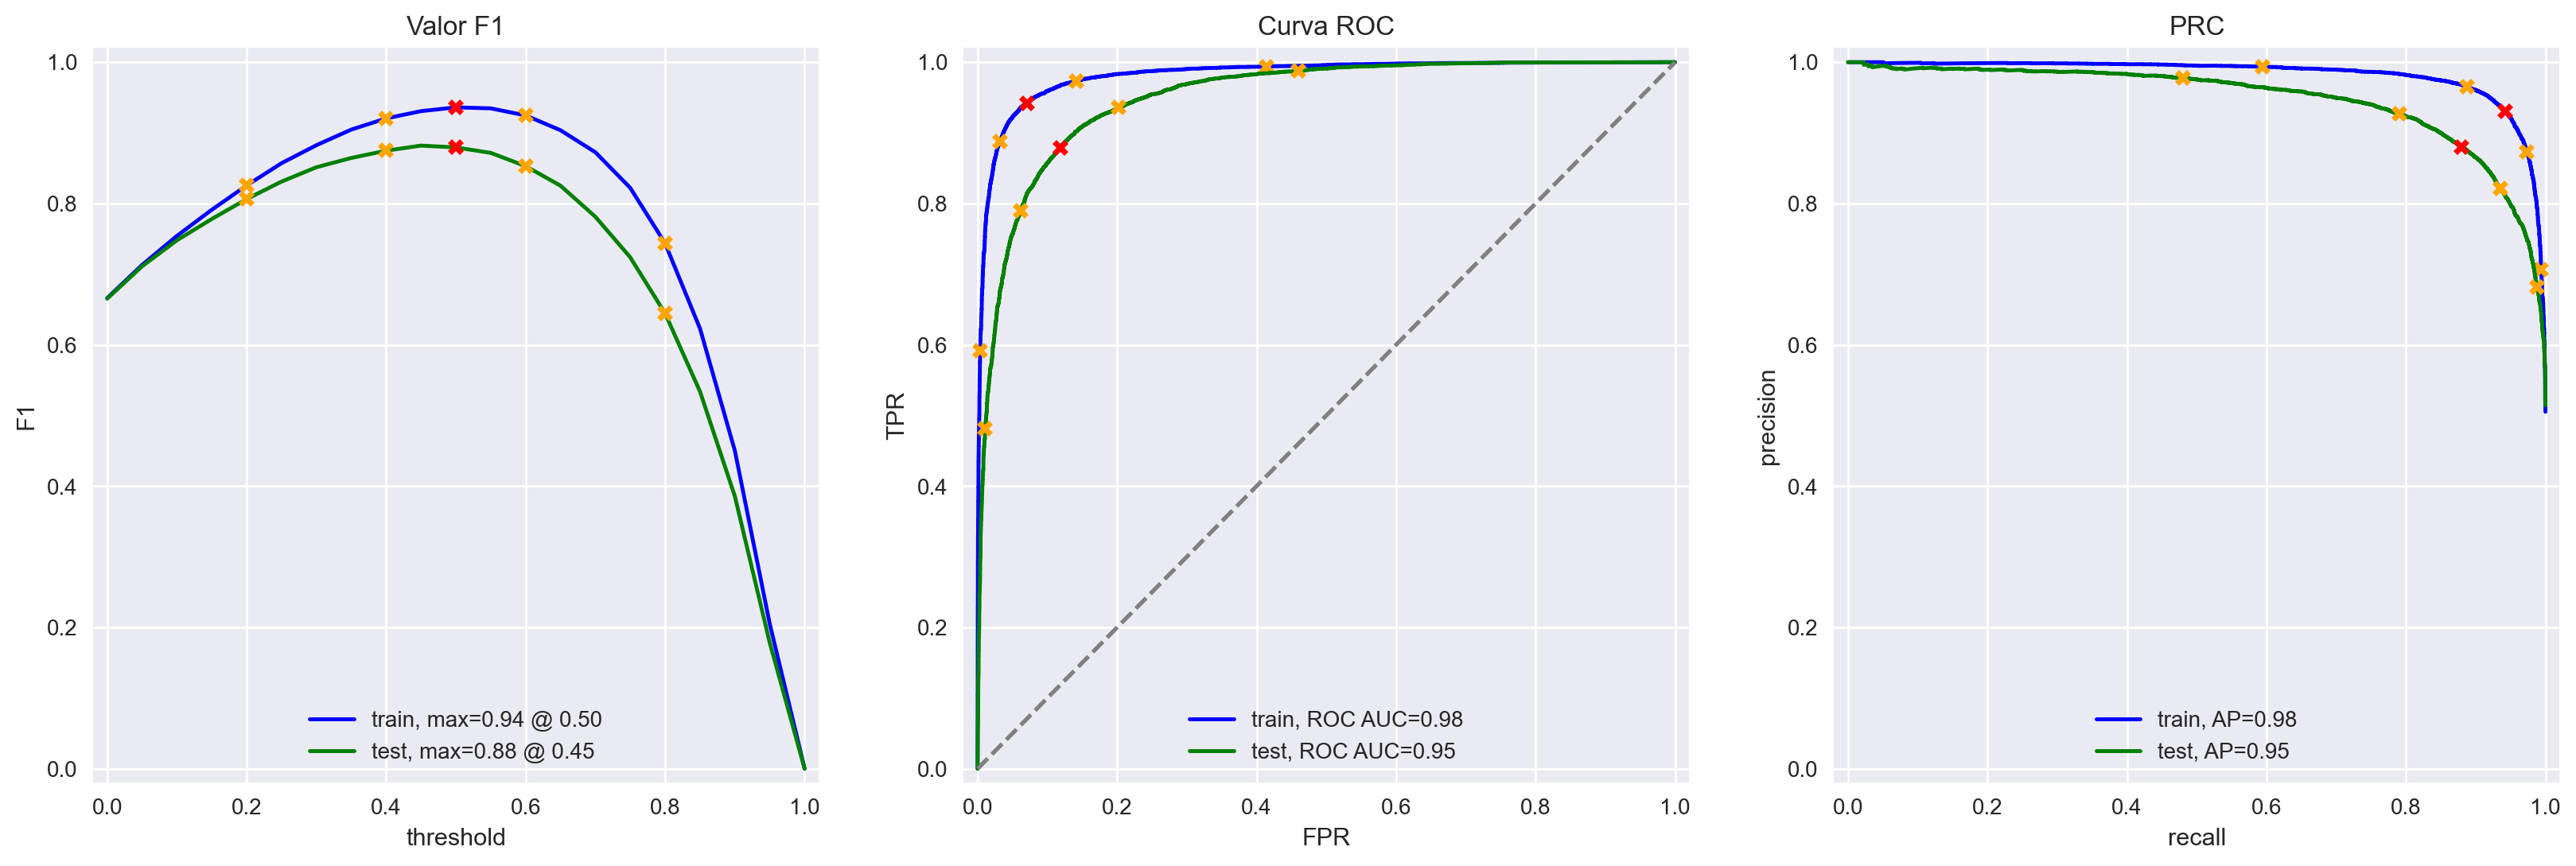

In [34]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_1 = LogisticRegression(C= 1.0, penalty= 'l2', solver='liblinear', random_state=1234)
model_1.fit(train_features_1, train_target)
#Evaluamos el modelo
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Observamos que nuestro modelo obtuvo como resultado un  **F1:0.88** en nuestro conjunto de prueba, claramente hemos superado nuestro modelo constante, y hemos superado el umbral solicitado de un F1 mayor a 0.85.

El ROC-AUC registrado en el conjunto de prueba fue de 0.95, superior al modelo aleatorio, la curva es alta, cercana a 1 indicando un modelo de alta calidad.

### Modelo 2 - NLTK, TF-IDF y LGBMClassifier

Primero, utilizaremos nuestros datos ya preprocesados. Cambiaremos el modelo de evaluación, utilizaremos un modelo de potenciación de gradiente, LGBMClassifier.

**NOTA:**  *El tiempo de ajuste de hiperparámetro se tardó aproximadamente 14 minutos, lo dejaremos como comentario y nos quedaremos con los mejores hiperparámetros que devolvió nuestro GridSearchCV.*

In [35]:
#%%time
#Establecemos los hiperparametros 
#params_lgbm_nltk = {
#    'objective': ['binary'],
#    'num_leaves' : [10, 20, 30],
#    'learning_rate' : [0.1, 0.2, 0.5],
#    'n_estimators' : [100],
#    'random_state' : [1234]
#}

#llamamos a GridSearchCV
#nltk_lgbm = GridSearchCV(LGBMClassifier(),
#                      param_grid = params_lgbm_nltk,
#                      scoring = 'f1',
#                      cv=3
#                      )
#Entrenamos el modelo
#nltk_lgbm.fit(train_features_1, train_target)

#Obtenemos los mejores hiperparametros
#print(f'Los mejores hiperparámetros para nltk_lgbm : {nltk_lgbm.best_params_}')
#print(f'Mejor valor F1 para nltk_lgbm : {nltk_lgbm.best_score_}')

**Mejores hiperparámetros:** *{'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 30, 'objective': 'binary', 'random_state': 1234}*

**Mejor valor para F1:** *0.8584624525837631*

Segundo, entrenamos y probamos nuestro modelo con los mejores hiperparámetros.

          train  test
Accuracy   0.95  0.87
F1         0.95  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


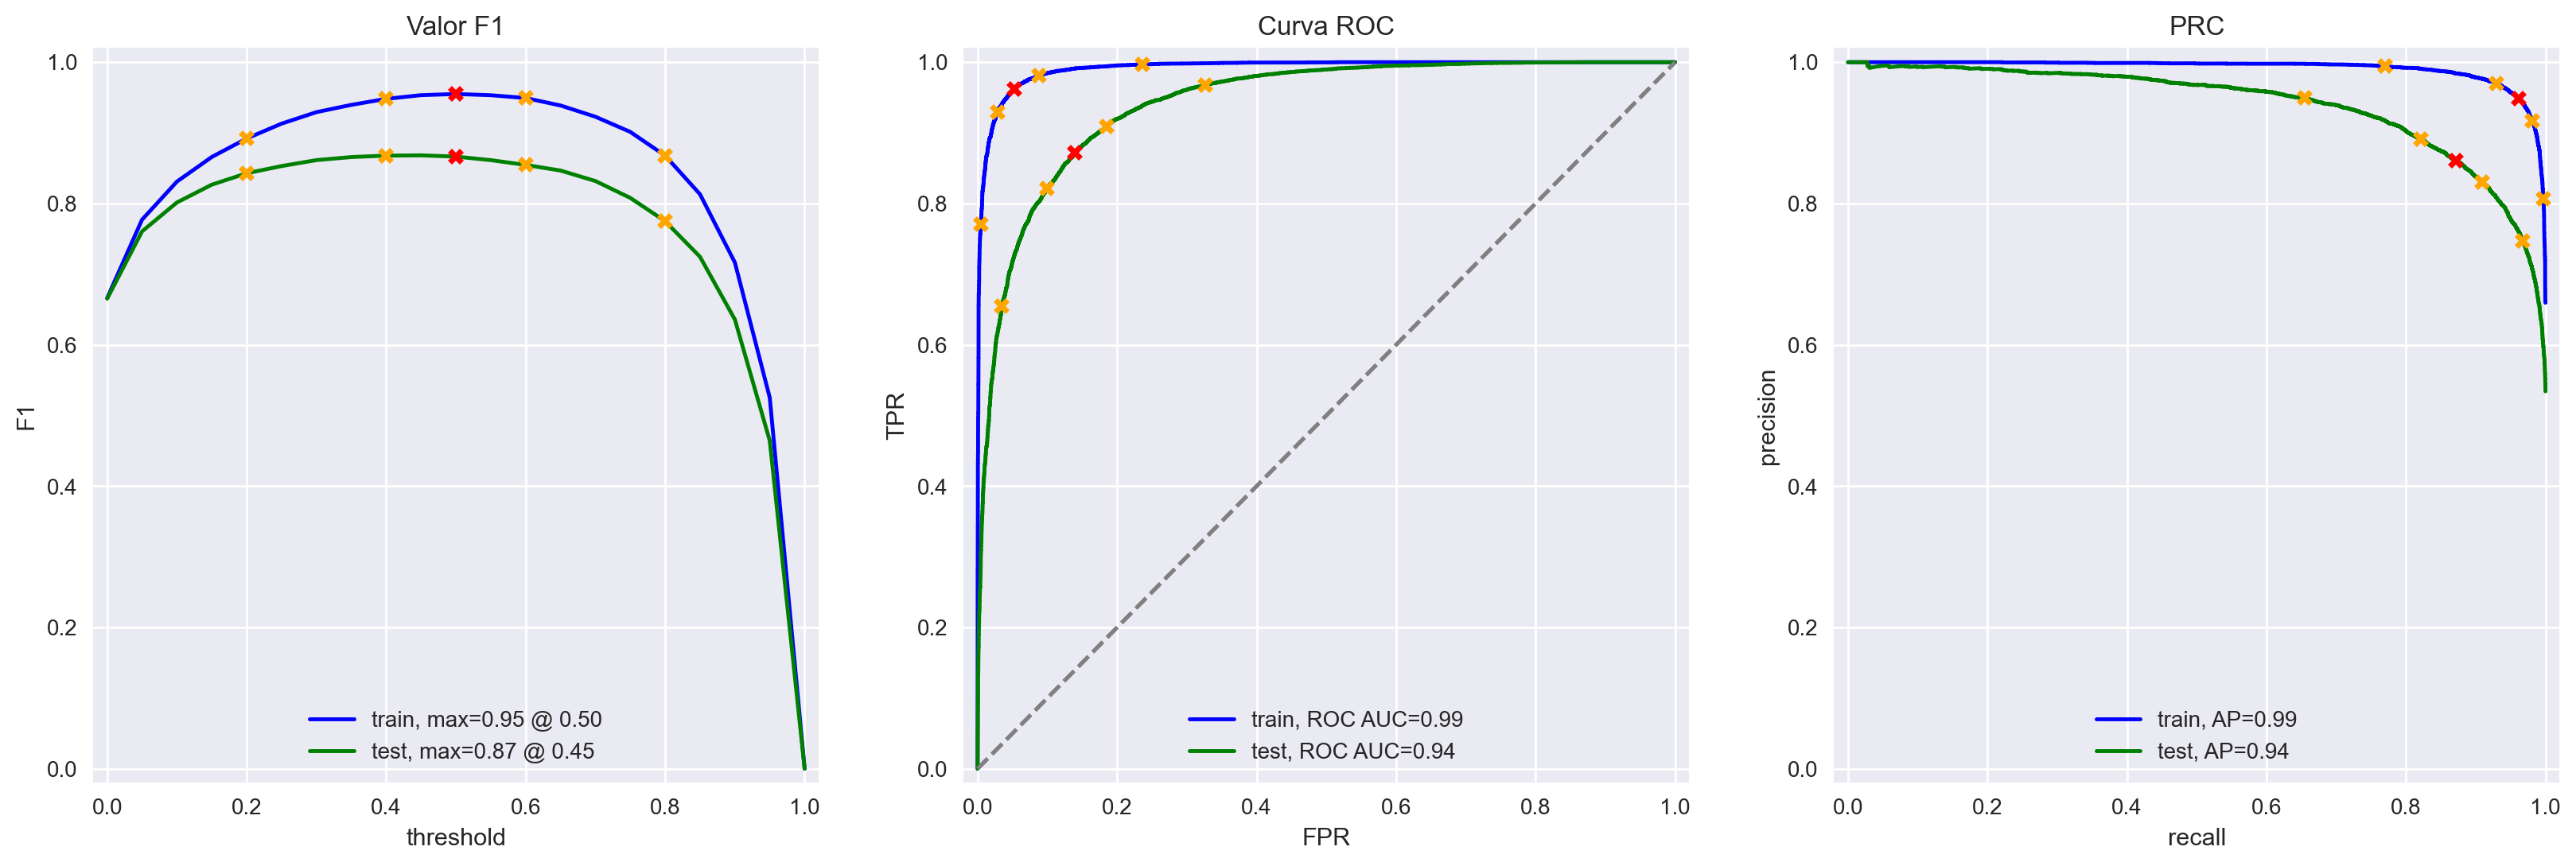

In [36]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_2 = LGBMClassifier(learning_rate=0.2,
                            n_estimators=100,
                            num_leaves=30,
                            objective='binary',
                            random_state=1234)

model_2.fit(train_features_1, train_target)
#Evaluamos el modelo
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

Observamos para nuestro segundo modelo un **F1:0.87** para el conjunto de prueba, esta métrica supera a la obtenida en nuestro modelo constante, y supera el umbral establecido en 0.85. Demostrando una buena relación sensibilidad-precisión en los umbrales 0.2 y 0.8. También se evidencia que a partir del umbral 0.8 el puntaje F1 tiende a disminuir.

La curva ROC-AUC muestra una curva alta, de 0.94 pero no supera el rendimineto de nuestro modelo_1.

### Modelo 3 - spaCy, TF-IDF y LR

Primero, tokenizaremos y lematizaremos pero en este modelo usaremos la librería spaCy para simplificar las reseñas.

In [37]:
#Cargamos el modelo de lenguaje
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
#Creamos una función para el preprocesamiento de las reseñas
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

**NOTA:** *El preprocesamiento de textos a través de nuestra función y el método apply, se tarda alrededor de unos 18 minutos, por lo cual recurriremos a np.load para generarlos una sola vez, guardarlos y cargarlos para cuando se necesiten.*

In [39]:
#%%time
#Aplicamos nuestra función al conjunto de prueba 
#train_spacy = df_reviews_train['review_norm'].apply(text_preprocessing_3)
#Aplicamos la función al conjunto de prueba
#test_spacy = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [41]:
#guardamos los textos lematizados en ambos conjuntos
#np.savez_compressed('corpus_spacy.npz', train_spacy = train_spacy, test_spacy = test_spacy)
#Cargamos los conjuntos de textos lematizados 
with np.load('corpus_spacy.npz', allow_pickle=True) as data:
    train_spacy=data['train_spacy']
    test_spacy=data['test_spacy']

In [42]:
#Comprobamos el tamaño de los conjuntos textos
print(train_spacy.shape)
print(test_spacy.shape)

(23796,)
(23535,)


Segundo, transformaremos las reseñas en datos númericos a través de la matriz TF-IDF

In [43]:
#Creamos un contador y definimos las paalabras vacías
stop_words = set(nltk_stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

#Calculamos el TF-IDF para el conjunto de entrenamiento
train_features_3 = tfidf_vectorizer_3.fit_transform(train_spacy)

#Calculamos el TF-IDF para el conjunto de prueba
test_features_3 = tfidf_vectorizer_3.transform(test_spacy)

#comprobamos el tamaño de las matrices 
print(train_features_3.shape)
print(test_features_3.shape)


(23796, 58981)
(23535, 58981)


Tercero, entrenaremos y probaremos el modelo de Regresión Logística con nuestro datos ya procesado y vectorizados.

In [44]:
%%time
#Establecemos los hiperparametros 
parameters = {
    'penalty': ['l1', 'l2'],
    'solver' : ['liblinear', 'saga'],
    'C' : [0.1, 1.0]
}

#llamamos a GridSearchCV
spacy_lr = GridSearchCV(LogisticRegression(random_state=1234),
                      param_grid = parameters,
                      scoring = 'f1',
                      cv=3
                      )
#Entrenamos el modelo
spacy_lr.fit(train_features_3, train_target)

#Obtenemos los mejores hiperparametros
print(f'Los mejores hiperparámetros para spacy_lr : {spacy_lr.best_params_}')
print(f'Mejor valor F1 para spacy : {spacy_lr.best_score_}')

Los mejores hiperparámetros para spacy_lr : {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
Mejor valor F1 para spacy : 0.8617124551984512
Wall time: 31.4 s


          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


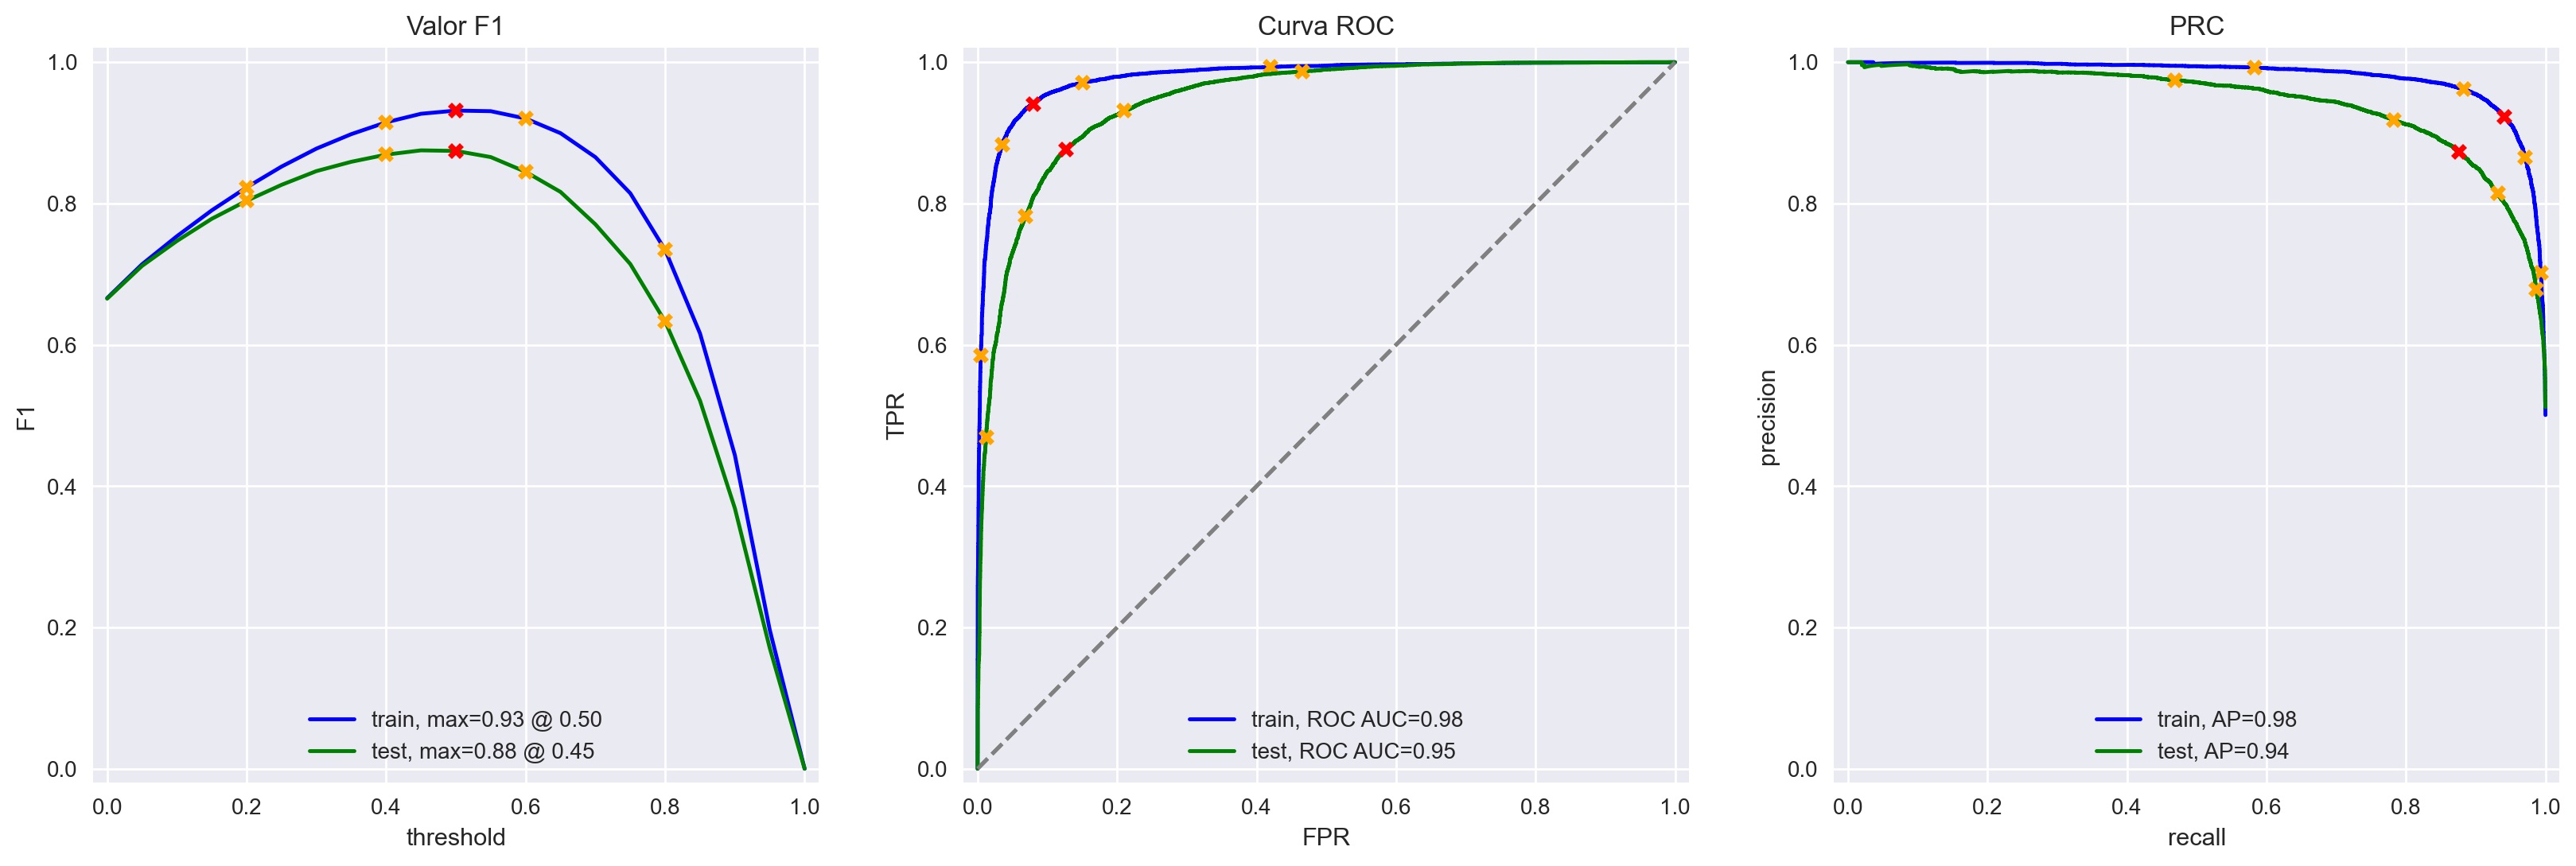

In [45]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_3 = LogisticRegression(C= 1.0, penalty= 'l2', solver='saga', random_state=1234)
model_3.fit(train_features_3, train_target)
#Evaluamos el modelo
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Observamos que nuestro modelo obtuvo un **F1:0.87** en nuestro conjunto de prueba, ha superado con éxito la calidad del modelo constante, y tambien ha superado el valor mínimo requerido de 0.85. También observamos que al comparar con nuestro modelo_1, el preprocesamiento (NLTK / spaCy) no influyo en gran medida en la métrica evaluada. 

Aunque podemos ver que en el model_1 las métricas en el conjunto de prueba son insignificativamente mejores.

La curva ROC-AUC muestra la calidad del modelo, en este caso siendo igual que el model_1. 

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

Primero, construiremos un modelo con los datos ya preprocesados en spaCy, en conjunto con el modelo de potenciación de gradiente LGBMClassifier.

**NOTA:** *Nuestra optimización de hiperparámetros tuvo uno duración de 13 minutos aproximadamente, lo dejaremos comentado y nos quedaremos con los mejores hiperparámetros que devuelve el GridSearchCV.*

In [46]:
#%%time
#Establecemos los hiperparametros 
#params_lgbm_spacy = {
#    'objective': ['binary'],
#    'num_leaves' : [10, 20, 30],
#    'learning_rate' : [0.1, 0.2, 0.5],
#    'n_estimators' : [100],
#    'random_state' : [1234]
#}

#llamamos a GridSearchCV
#spacy_lgbm = GridSearchCV(LGBMClassifier(),
#                      param_grid = params_lgbm_spacy,
#                      scoring = 'f1',
#                      cv=3
#                      )
#Entrenamos el modelo
#spacy_lgbm.fit(train_features_3, train_target)

#Obtenemos los mejores hiperparametros
#print(f'Los mejores hiperparámetros para spacy_lgbm : {spacy_lgbm.best_params_}')
#print(f'Mejor valor F1 para spacy_lgbm : {spacy_lgbm.best_score_}')

**Mejores hiperparámetros:** *{'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 30, 'objective': 'binary', 'random_state': 1234}*
**Mejor valor F1:** *0.8517092062759438*

          train  test
Accuracy   0.95  0.86
F1         0.95  0.86
APS        0.99  0.93
ROC AUC    0.99  0.94


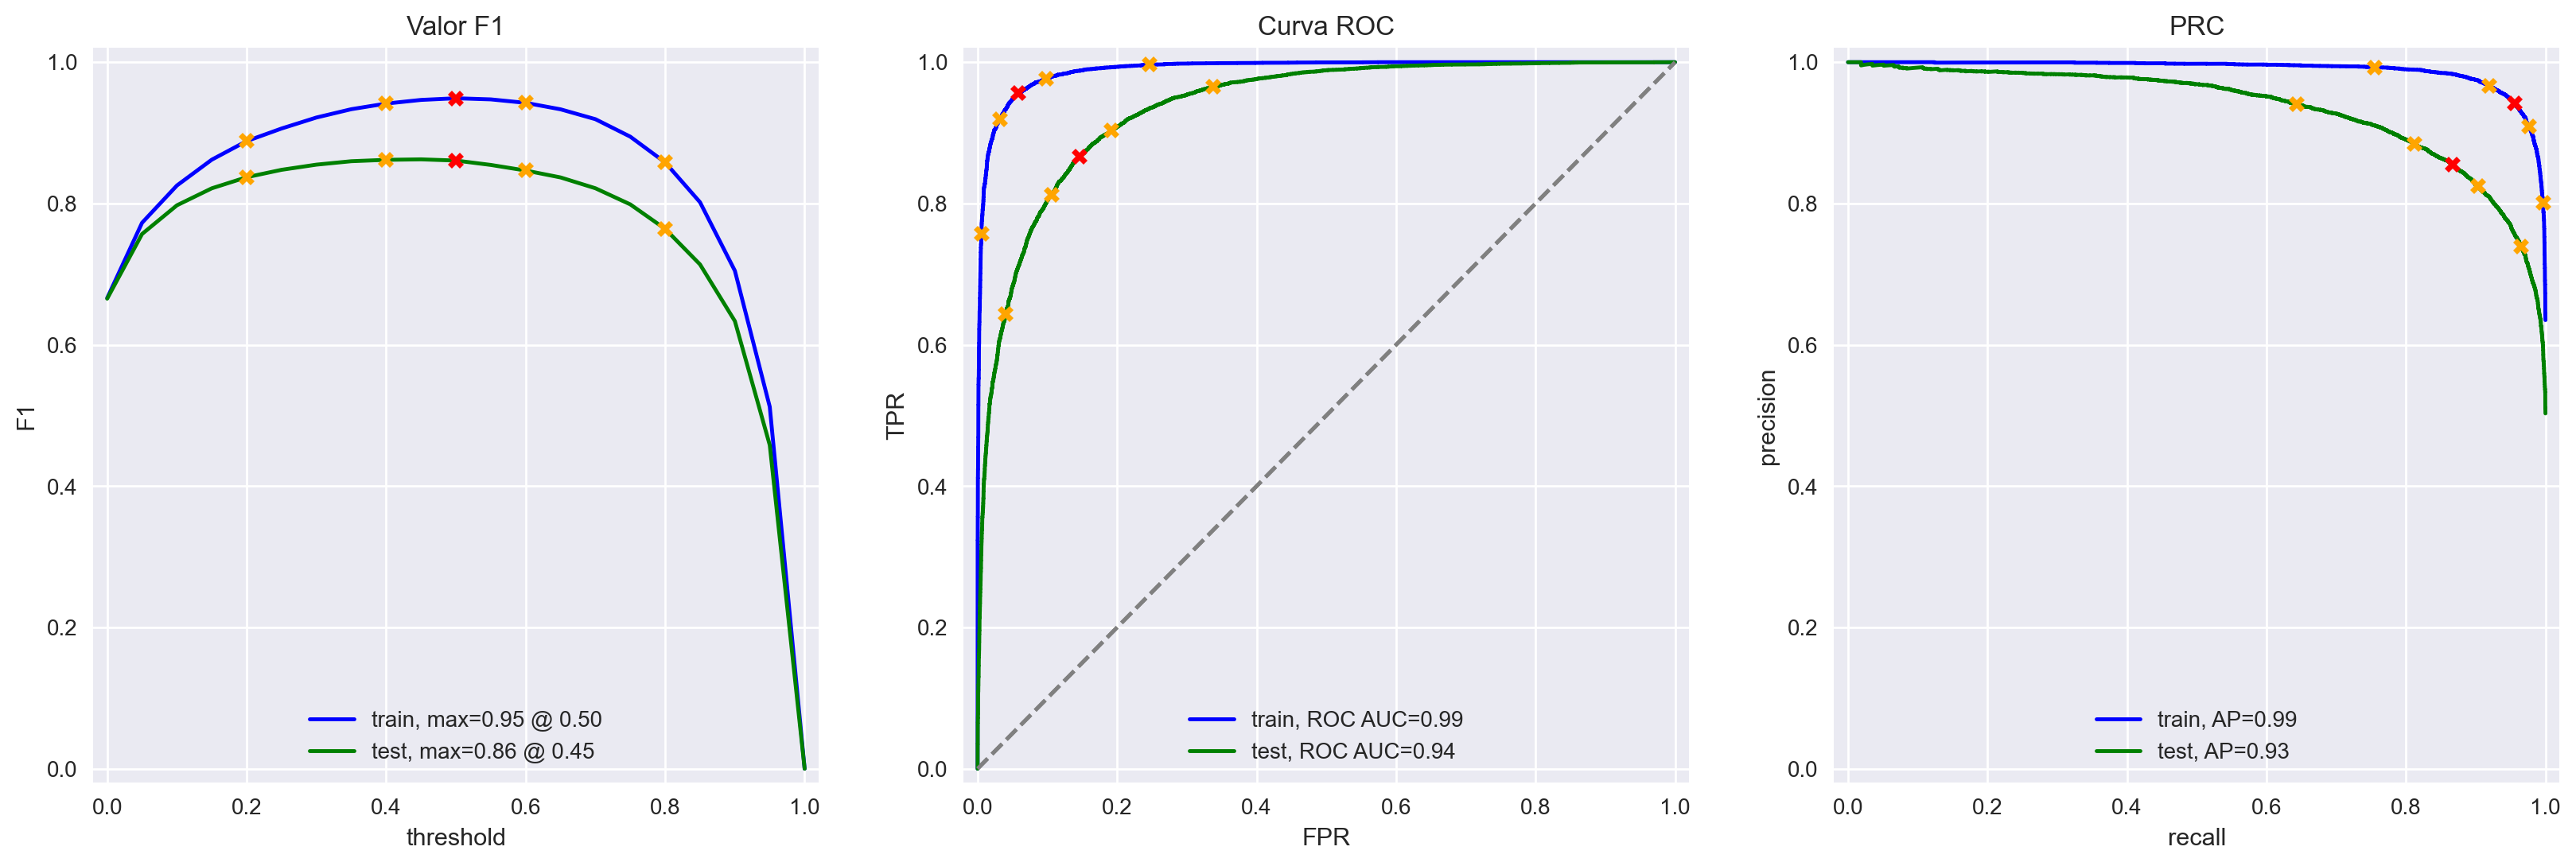

In [47]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_4 = LGBMClassifier(learning_rate=0.2,
                            n_estimators=100,
                            num_leaves=30,
                            objective='binary',
                            random_state=1234)

model_4.fit(train_features_3, train_target)
#Evaluamos el modelo
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

Observamos que nuestro modelo obtuvo un **F1:0.86**, mostrando un rendimiento parecido al modelo preprocesado con NLTK, podemos inferir, que entres estos dos métodos de preprocesamiento no se genera una diferencia significativa en sus rendimientos. Queda demostrado con estos modelos que los de Regresión Logística presentan mejores rendimientos en comparación con los de potenciación de gradiente (que necesitan más tiempo de procesamiento).

###  Modelo 5 - BERT LR

El modelo BERT (Bidirectional Encoder Representations from Transformers). BERT es una red neuronal profunda basada en la arquitectura de transformadores, y su principal característica es que es preentrenado en grandes cantidades de texto sin etiquetar, lo que le permite aprender representaciones de palabras y oraciones contextualizadas.

La idea principal detrás de BERT es que se entrena para predecir palabras o tokens faltantes en un contexto dado. Para esto, se introduce un enmascaramiento de palabras en el texto de entrada antes de alimentar al modelo. De esta manera, BERT aprende a entender la relación entre las palabras y oraciones en un contexto más amplio.

Realizaremos el preprocesamiento con BERT para luego usar el modelo de Regresión Logística. 

In [48]:
#Iniciamos el tokenizador
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

#Iniciamos la configuración
config = transformers.BertConfig.from_pretrained('bert-base-uncased')

#Iniciamos el modelo
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [49]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
         
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)


        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [51]:
# Obtenemos los insertados para ambos conjuntos
#train_features_5 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
#test_features_5 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [52]:
#Guaradamos los insertados
#np.savez_compressed('features_5.npz', train_features_5=train_features_5, test_features_5=test_features_5)
#Cargamos los insertados
with np.load('features_5.npz') as data:
    train_features_5 = data['train_features_5']
    test_features_5 = data['test_features_5']

In [53]:
#Comprobamos el tamaño de entrenamiento
print(df_reviews_train['review_norm'].shape)
print(train_features_5.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [54]:
#Comprobamos el tamaño de prueba
print(df_reviews_test['review_norm'].shape)
print(test_features_5.shape)
print(test_target.shape)

(23535,)
(23535, 768)
(23535,)


Entrenaremos el modelo de Regresión Logística con nuestros datos preprocesados con BERT

**NOTA:** *La busqueda de mejores hiperparámetros para el modelo 5 tuvó una duración de aproximadamente 13 minutos, por lo cual lo dejaremos comentado y tomaremos los mejores hiperparámetros para entrenar nuestro modelo*

In [55]:
#%%time
#Establecemos los hiperparametros 
#params_bert_lr = {
#    'penalty': ['l1', 'l2'],
#    'solver' : ['liblinear', 'saga'],
#    'C' : [0.1, 1.0]
#}

#llamamos a GridSearchCV
#bert_lr = GridSearchCV(LogisticRegression(random_state=1234),
#                      param_grid = params_bert_lr,
#                      scoring = 'f1',
#                      cv=3
#                      )
#Entrenamos el modelo
#bert_lr.fit(train_features_5, train_target)

#Obtenemos los mejores hiperparametros
#print(f'Los mejores hiperparámetros para bert_lr : {bert_lr.best_params_}')
#print(f'Mejor valor F1 para bert_lr : {bert_lr.best_score_}')

**Los mejores hiperparámetros para bert_lr:** *{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}*

**Mejor valor F1 para bert_lr:**  *0.8570551337162368*

          train  test
Accuracy   0.87  0.87
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


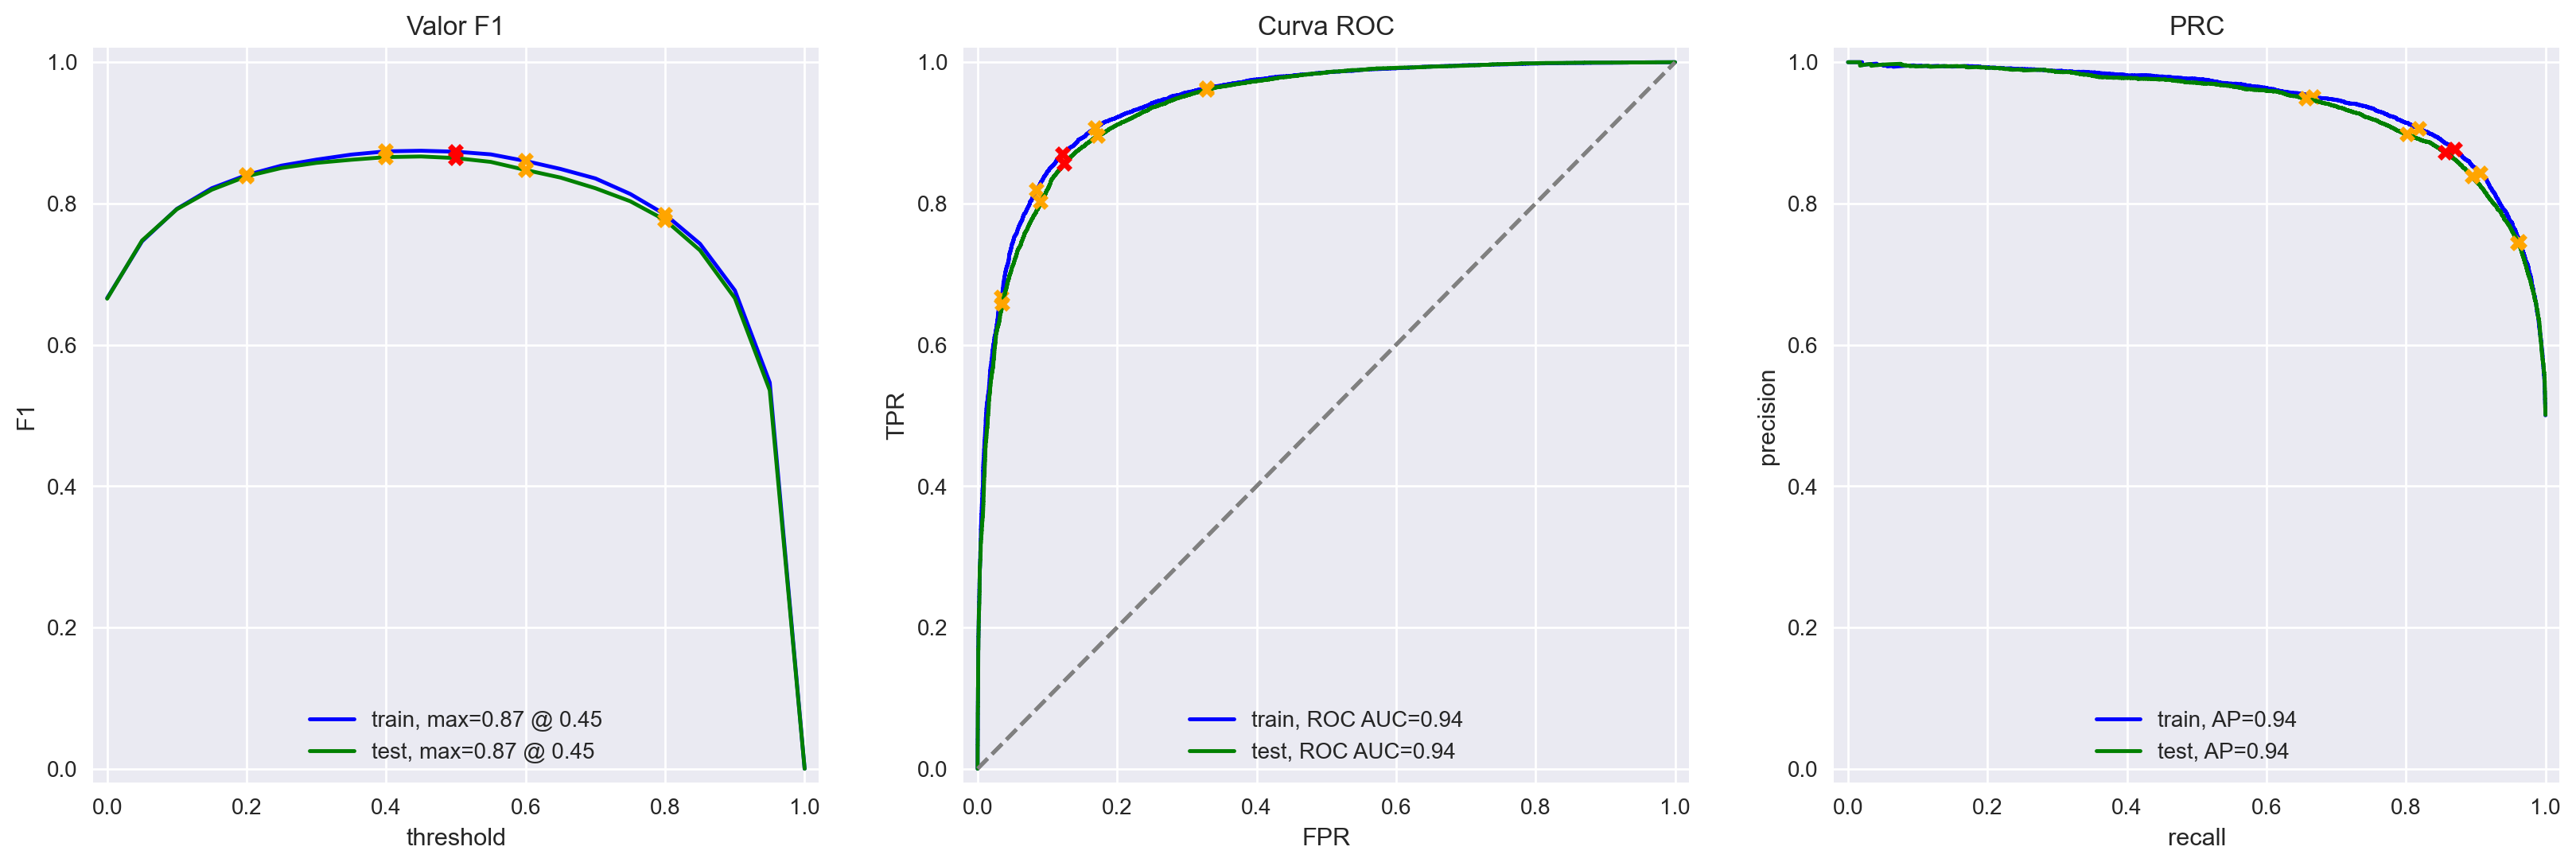

In [56]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_5 = LogisticRegression(C= 0.1, penalty= 'l2', solver='liblinear', random_state=1234)
model_5.fit(train_features_5, train_target)
#Evaluamos el modelo
evaluate_model(model_5, train_features_5, train_target, test_features_5, test_target)

Observamos que nuestro modelo obtuvo un **F1:0.86**, casi no supera el umbral mínimo solicitado, pero observamos que el sobreajuste es muy poco a diferencia de nuestro modelos anteriores, los resultados tanto en el conjunto de prueba y el conjunto de entrenamiento presentan diferencias por muy poco, incluso nulas en algunos rendimientos, ejemplo en la curva ROC- AUC, que para ambos conjuntos es 0.94.

### Modelo 6 - BERT LGBMClassifier

**NOTA:** *La busqueda de mejores hiperparámetros para el modelo 6 tuvó una duración de aproximadamente 10 minutos, por lo cual lo dejaremos comentado y tomaremos los mejores hiperparámetros para entrenar nuestro modelo*

In [57]:
#%%time
#Establecemos los hiperparametros 
#params_bert_lgbm= {
#    'objective': ['binary'],
#    'num_leaves' : [10, 20, 30],
#    'learning_rate' : [0.01, 0.05, 0.1],
#    'n_estimators' : [100]
#}

#llamamos a GridSearchCV
#bert_lgbm = GridSearchCV(LGBMClassifier(random_state=1234),
#                      param_grid = params_bert_lgbm,
#                      scoring = 'f1',
#                      cv=3
#                      )
#Entrenamos el modelo
#bert_lgbm.fit(train_features_5, train_target)

#Obtenemos los mejores hiperparametros
#print(f'Los mejores hiperparámetros para bert_lgbm : {bert_lgbm.best_params_}')
#print(f'Mejor valor F1 para bert_lgbm : {bert_lgbm.best_score_}')

**Los mejores hiperparámetros para bert_lgbm :** *{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 30, 'objective': 'binary'}*

**Mejor valor F1 para bert_lgbm :** *0.8297187342629418*

          train  test
Accuracy   0.92  0.83
F1         0.92  0.83
APS        0.98  0.92
ROC AUC    0.98  0.92


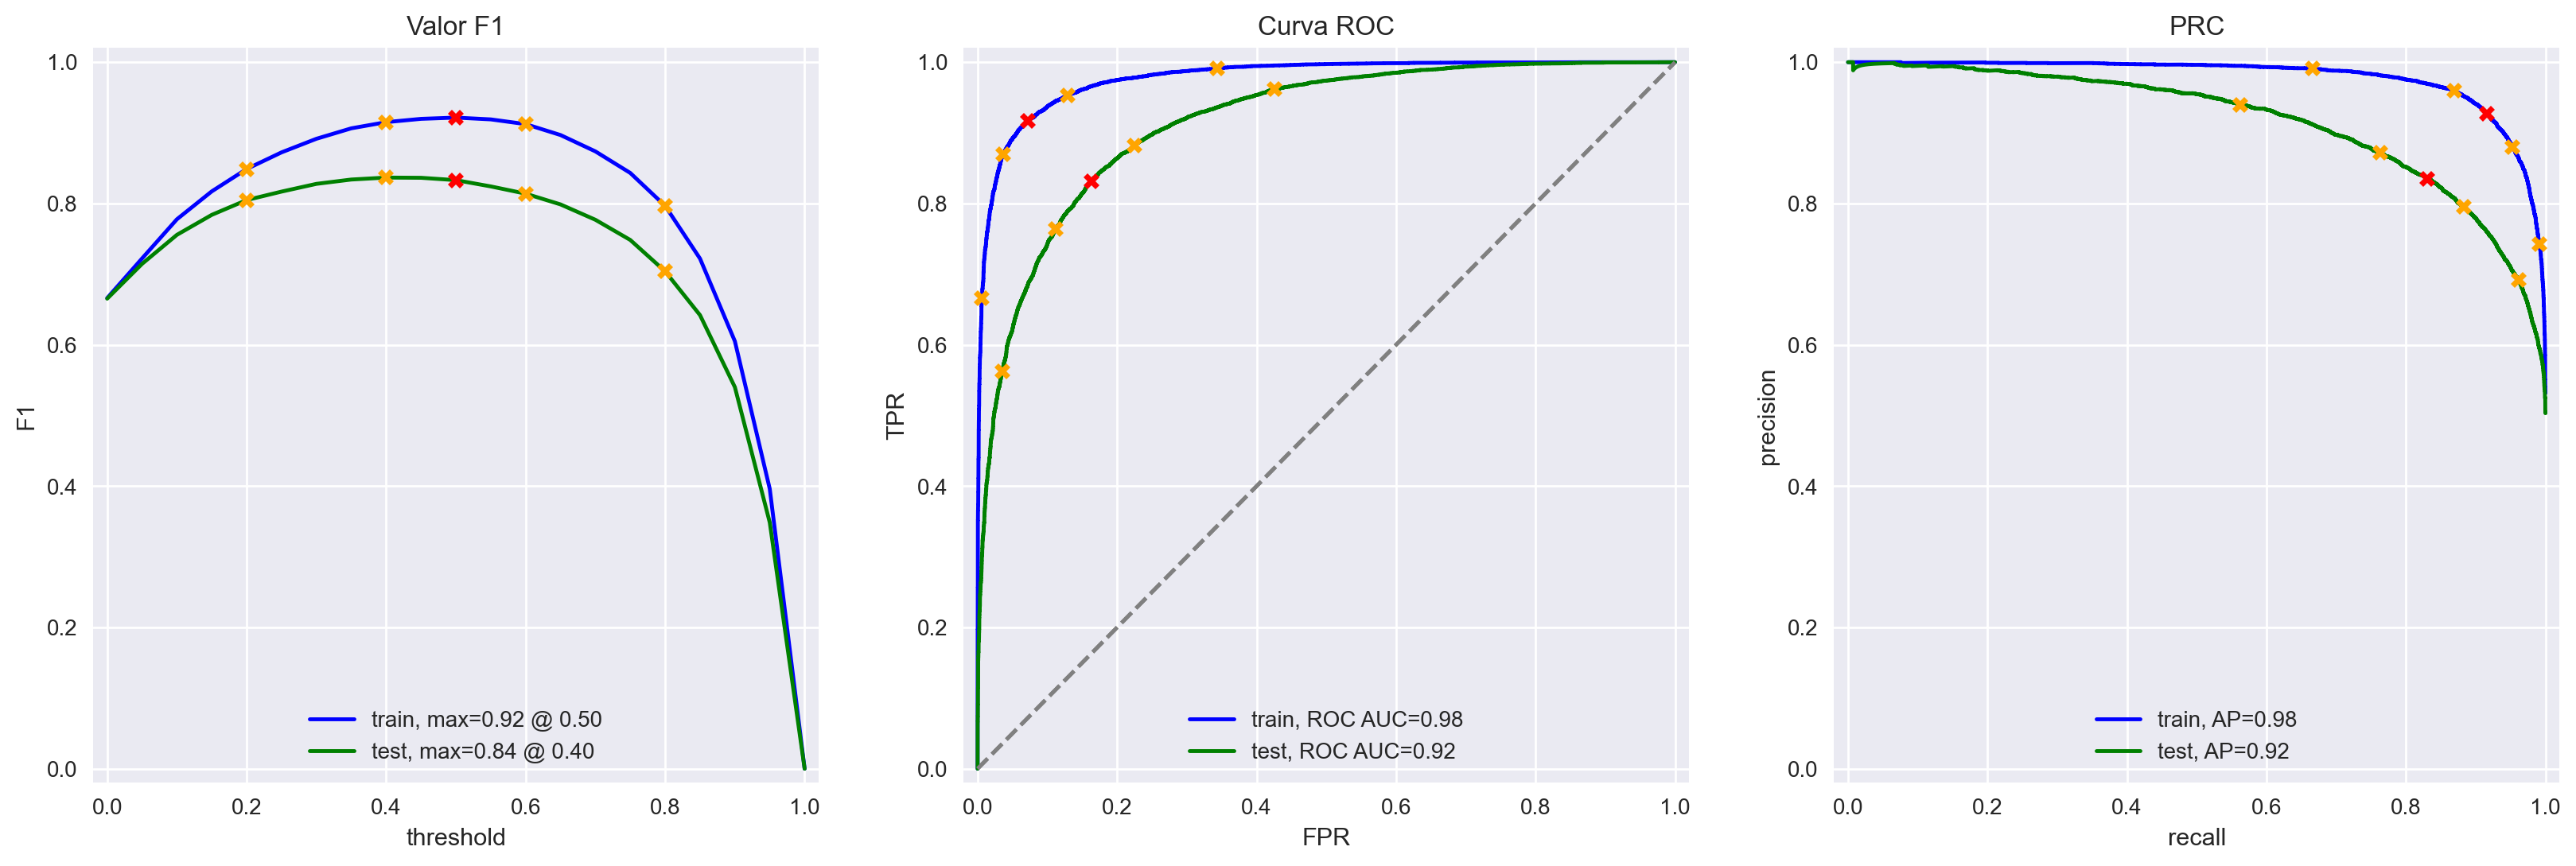

In [58]:
#Entrenamos nuestro modelo con los mejores hiperparametros 
model_6 = LGBMClassifier(learning_rate=0.1,
                            n_estimators=100,
                            num_leaves=30,
                            objective='binary',
                            random_state=1234)

model_6.fit(train_features_5, train_target)
#Evaluamos el modelo
evaluate_model(model_6, train_features_5, train_target, test_features_5, test_target)

Observamos que nuestro modelo obtuvo un **F1:0.83** por lo cual no pasa el umbral de prueba requerido, tambien podemos observar un alto sobreajuste en nuestro modelo, lo que explica su deficiencia para realizar predicciones en conjuntos nuevos de datos. 

## Mis reseñas

Tenemos a continuación varías reseñas con las que probaremos nuestros modelos, para medir su predicciones con respecto al análisis de sentimiento dentro de estas reseñas tenemos negativas y positivas.

In [59]:
# Reseñas de prueba

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1


In [60]:
#Establecemos las variables de texto y de sentimiento 
texts = my_reviews['review_norm']
sentiment = my_reviews['pos']

### Modelo 1

In [61]:
my_reviews_pred = model_1.predict(tfidf_vectorizer_1.transform(texts))
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

Pos Pred Prob Review
0    0    0.16    i did not simply like it not my kind of movie
0    0    0.18    well i was bored and felt asleep in the middle of the movie
1    1    0.58    i was really fascinated with the movie
0    0    0.17    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    0    0.39    i didn't expect the reboot to be so good writers really cared about the source material
1    0    0.49    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.09    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.89    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 1 logró predecir correctamente 6 de 8 reseñas, falló en sus predicciones al colocar dos reseñas positivas como negativas. Aunque estas dos reseña tenían porcentajes mas altos que las reseñas negativas reales, no fue suficiente para calificarlas como positivas, en el contexto vemos el uno de (didn't, downsides) que son negaciones. 

### Modelo 2

In [62]:
my_reviews_pred = model_2.predict(tfidf_vectorizer_1.transform(texts))
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

Pos Pred Prob Review
0    1    0.56    i did not simply like it not my kind of movie
0    1    0.50    well i was bored and felt asleep in the middle of the movie
1    1    0.58    i was really fascinated with the movie
0    0    0.26    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    0    0.43    i didn't expect the reboot to be so good writers really cared about the source material
1    1    0.64    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.22    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.78    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 2 logró predecir correctamente 5 de 8 reseñas, falló en sus predicciones al colocar dos reseñas negativas como positivas, y una reseña positiva como negativa, en el contexto podriamos inferir que el usar las palabras (did, like) o la ausencia de negaciones, pudo conducir a un error en la predicción para el caso de reseñas negativas que predijo como positivas, en el caso contrario volvemos a observar el comportamiento de una reseña positiva que usa la expresión (didn't) y que falla al predecir colocandola como negativa.

### Modelo 3

In [63]:
my_reviews_pred = model_3.predict(tfidf_vectorizer_3.transform(texts))
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

Pos Pred Prob Review
0    0    0.16    i did not simply like it not my kind of movie
0    0    0.12    well i was bored and felt asleep in the middle of the movie
1    1    0.50    i was really fascinated with the movie
0    0    0.42    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    0    0.44    i didn't expect the reboot to be so good writers really cared about the source material
1    1    0.56    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.11    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.95    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 3 logró predecir correctamente 7 de 8 reseñas, falló solo en una predicción al colocar una reseña positiva como negativa, es la misma reseña que ha tenido errores para predecir, al estar presente la expresión (didn't) es posible que la probabilidad de ser positiva baje, por lo cual termina siendo negativa la predicción.

### Modelo 4

In [64]:
my_reviews_pred = model_4.predict(tfidf_vectorizer_3.transform(texts))
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

Pos Pred Prob Review
0    1    0.53    i did not simply like it not my kind of movie
0    0    0.14    well i was bored and felt asleep in the middle of the movie
1    1    0.54    i was really fascinated with the movie
0    1    0.54    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    1    0.64    i didn't expect the reboot to be so good writers really cared about the source material
1    1    0.66    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.23    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.88    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 4 logró predecir 6 de 8 reseñas correctamente, falló al predecir dos reseñas negativas que marco como positivas. Para nuestro primer caso podriamos pensar que al usar palabras como (kind, did o like) confunda a nuestro modelo y no pueda unir todas las palabras en el contexto que realmente tiene. En el segundo caso vemos que a pesar de estar presenta la palabra (desinteresed) el modelo lo califica como reseña positiva, es posible que con reseñas mas largas (como esta), el modelo pierde el contexto y por ende se equivoca en su predcción, igualmente podemos decir que no se equivocó un niguna reseña positiva.

### Modelo 5

In [65]:
my_reviews_features_5 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred = model_5.predict(my_reviews_features_5)
my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_5)[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

C:\Users\adrik\AppData\Local\Temp\ipykernel_10316\1695621218.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


Pos Pred Prob Review
0    0    0.26    i did not simply like it not my kind of movie
0    0    0.01    well i was bored and felt asleep in the middle of the movie
1    1    0.97    i was really fascinated with the movie
0    0    0.00    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    0    0.18    i didn't expect the reboot to be so good writers really cared about the source material
1    1    0.94    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.06    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.94    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 5 logró predecir 7 de 8 reseñas correctamente, falló al predecir una reseña positiva como negativa, observamos que tenemos la misma reseña que anteriormente presenta problemas para su predicción, a lo cual atribuimos a la presencia de la expresión (didn't), esta negación podría estar afectando todo el contexto de la oración. Igualmente vemos que tiene una probabilidad baja (es decir que para el modelo esta oración esta muy lejos de ser positiva). 

### Modelo 6

In [66]:
my_reviews_features_6 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred = model_6.predict(my_reviews_features_6)
my_reviews_pred_prob = model_6.predict_proba(my_reviews_features_6)[:, 1]

print('Pos'+' '+'Pred'+' '+'Prob'+' '+'Review')

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{sentiment[i]}    {my_reviews_pred[i]}    {my_reviews_pred_prob[i]:.2f}    {review}')

Pos Pred Prob Review
0    0    0.41    i did not simply like it not my kind of movie
0    0    0.05    well i was bored and felt asleep in the middle of the movie
1    1    0.72    i was really fascinated with the movie
0    0    0.07    even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1    0    0.27    i didn't expect the reboot to be so good writers really cared about the source material
1    1    0.84    the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0    0    0.05    what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1    1    0.95    launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuestro modelo 6 presenta los mismo resultados que nuestro modelo 5, con la diferencia de que esta reseña tiene una probabilidad más alta de ser positiva, podriamos creer que entiende un poco más el contexto de las reseñas. 

### Análisis de modelos

In [67]:
models = pd.DataFrame({
    'modelo' : ['Modelo constante',
                'NLTK y LR',
                'NLTK y LGBMClassifier',
                'spaCy y LR',
                'spaCy y LGBMClassifier', 
                'BERT LR',
                'BERT LGBMClassifier'],
    'F1' : [0.67, 0.88, 0.87, 0.87, 0.86, 0.86, 0.83 ]
}).sort_values(ascending=False, by='F1')

models

,modelo,F1
1,NLTK y LR,0.88
2,NLTK y LGBMClassifier,0.87
3,spaCy y LR,0.87
4,spaCy y LGBMClassifier,0.86
5,BERT LR,0.86
6,BERT LGBMClassifier,0.83
0,Modelo constante,0.67


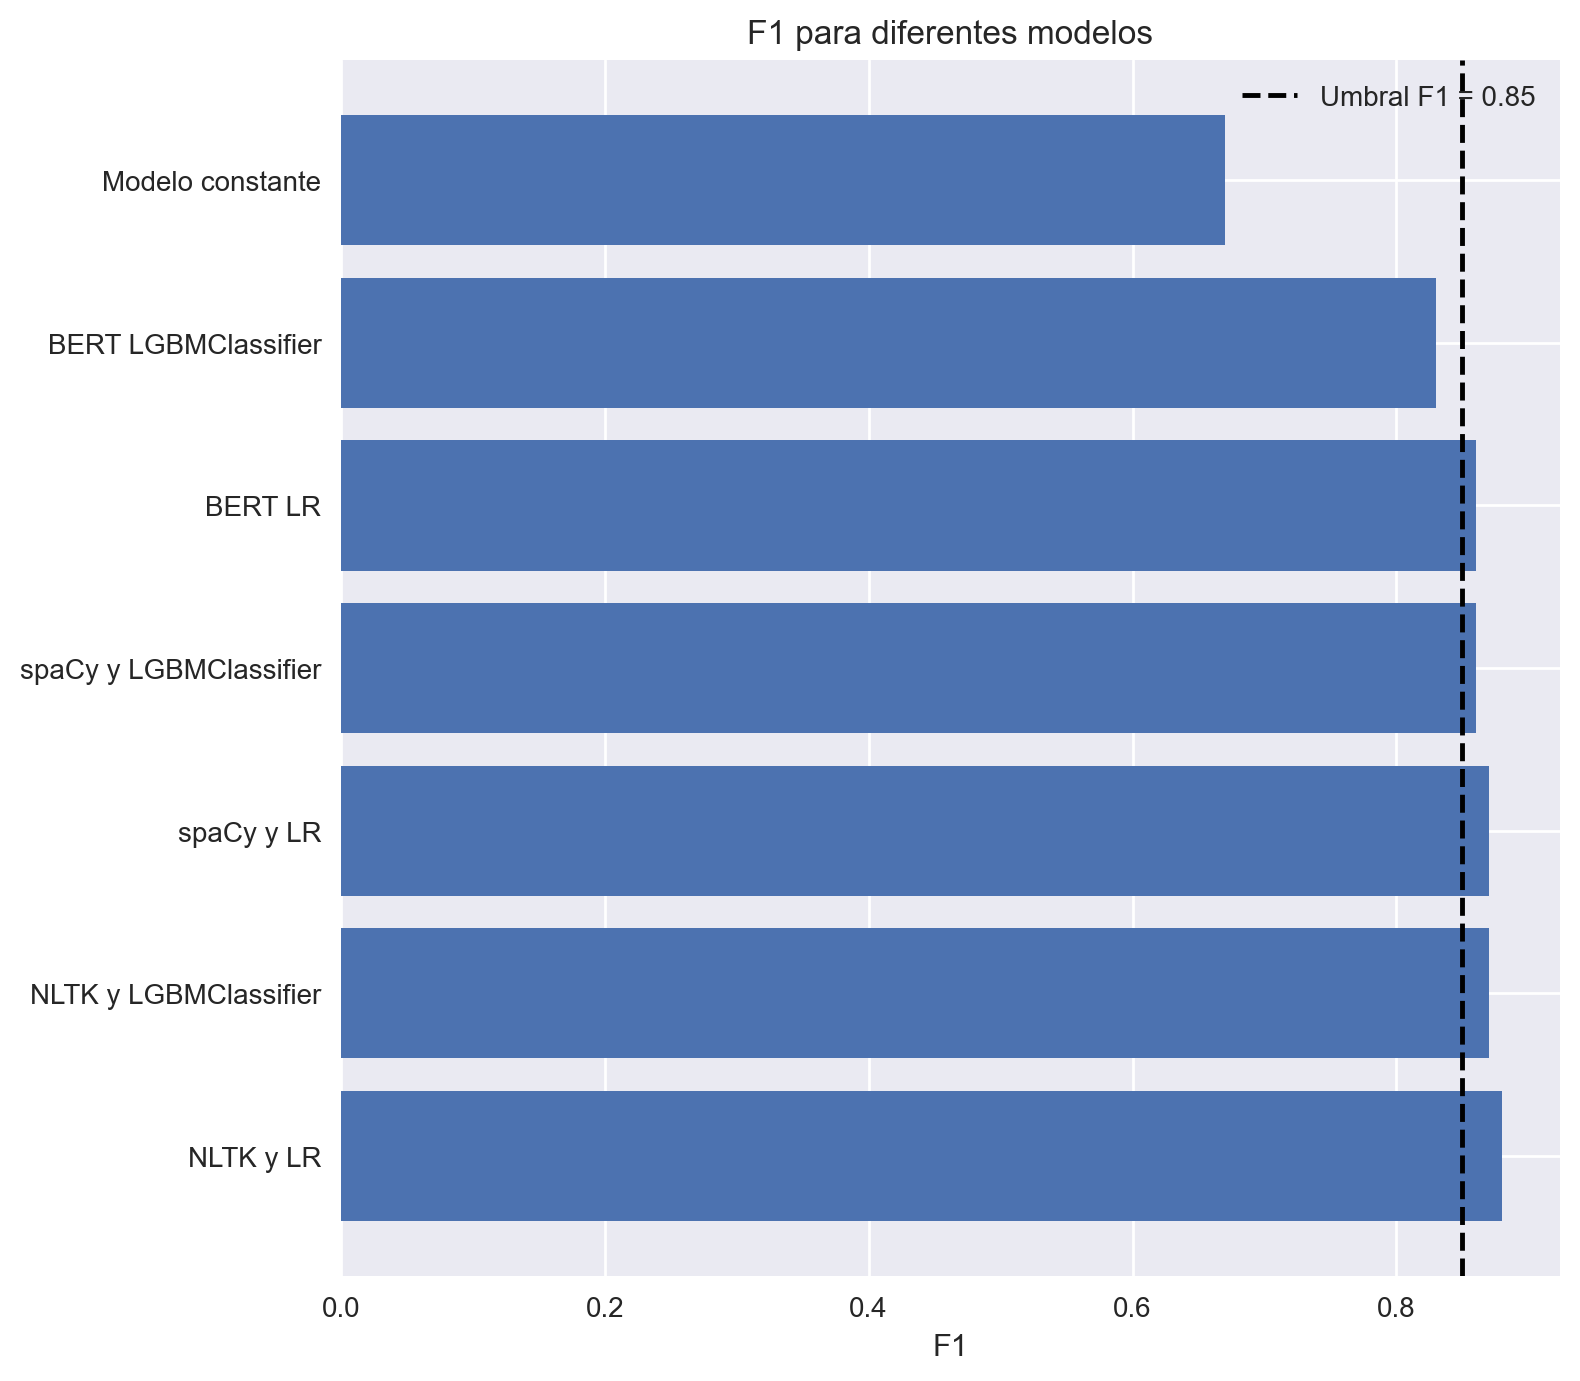

In [68]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(8, 7))
bars = plt.barh(models['modelo'], models['F1'])

# Marcar el umbral F1
plt.axvline(x=0.85, color='black', linestyle='--', label='Umbral F1 = 0.85')

# Ajustar estilo y etiquetas
plt.xlabel('F1')
plt.title('F1 para diferentes modelos')
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los modelos que presetaron mejores resultados fueron en cuanto a las predicciones fueron:
- spaCy y LR (modelo 3)
- BERT LR (modelo 5)
- BERT LGBMClasiffier (modelo 6)

Estos modelos no obtuvieron el mejor F1. Pero fueron los que presentaron menos sobreajuste, al entender mejor el conjunto de datos lograron acertar mejor en las predicciones. Estos modelos fallaron el predecir la misma reseña, es decir, tuvieron problemas para clasificar una reseña positiva que presentaba una negación en su contexto. 

## Conclusiones

**Exploración de datos**
1. Observamos  un par de valores nulos (average_rating, votes) y dos tipos de datos incorrectos (end_year, runtime_minutes). Pero para nuestro caso en el que solo importaban las reseñas y la clasificación (pos) decidimos dejar el dataset sin cambios, ya que las características que requeriamos estaban correctas. 

**EDA**
1. El número de críticas tiende a aumentar en la medidad que aumentan la cantidad de películas, conseguimos el pico más alto en el 2006. Este evento lo relacionamos con el avance de la tecnología que facilita la producción de películas y un entorno más amplio para transmitir las opiniones de cada usuario. 

2. Observamos que la mayoría de películas tienen pocas reseñas (1-10), aunque se pudo distinguir un pequeño grupo de películas que logró recibir hasta 30 reseñas, también observamos que mientras aumentaban el número de reseñas, estas eran positivas. Este mismo comportamiento explica que a menor cantidad de reseñas, la polaridad dominante es la negativa. 

**Modelos**
1. Para poder realizar un análisis de sentimiento adecuado, se preprocesaron las reseñas, la limpieza de texto nos permitió quitar caracteres extraños, signos de puntuación, espacios adicionales o dígitos.
2. Para completar este preprocesamiento tuvimos que tokenizar y lematizar las reseñas, esto para llevarlas a su expresión más basica y poder hacer el procesos de análisis más sencillo, por lo cual usamos NLTK, spaCy y BERT. Para NLTK y spaCy, se completo el procesamiento con la vectorización de las reseñas a través de TF-IDF. En el caso e BERT, se construyó una función para obtener insertados de palabras.

*destacar que para obtener los insertados de bert se necesito un entorno GPU, por el cual se trabajo en google colab, se guardo y subimos los resultados en el proyecto, esto con el fin de disminuir el tiempo de ejecución.*

3. El modelo que obtuvo la mejor métrica de **F1** fue el modelo 1, preprocesado con NLTK y aplicando un modelo de Regresión Logística. Su puntaje tuvo un resultado de 0.88, pero tambien es un modelo que presenta mayor sobreajuste y que pudimos comprobar al hacer pruebas con reseñas nuevas. Aunque falló dos de ocho predicciones, modelos que presentaron menor **F1** fallarón en menos. 

4. Los modelos que presentarón menos fallos en las predicciones con nuevas reseñas (creadas por nosotros) fueron los modelos BERT (modelos 5 y 6) lo cual tiene sentido porque estos modelos no presentaron sobreajuste, demostrando que el modelo logró aprender del conjunto de prueba. El modelo spaCy con Regresión Logística también presento solo un fallo en la predicción con probabilidades muy buenas, este modelo igualmente presenta mayor sobreajuste.

5. Destacamos que nuestros modelos BERT a pesar de su carga computacional, muestran mayor desempeño a la hora de predecir para nuevas reseñas, con un mejor ajuste de hiperparametros es posible alcanzar **F1** más altos.

6. En nuestra muestra de prueba, observamos que las reseñas que presentaban negaciones dentro de un contexto positivo condujo al error del modelo, dejando en claro que los modelos son buenos para predecir reseñas negativas, teniendo en cuenta este comportamiento, podriamos generar muestras de reseñas negativas explicitas como implicitas, para que el modelo pueda aprender de estos contextos y obtener mejores resultados.  